In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic"

Mounted at /content/drive


###Install & Import Packages

In [ ]:
!pip install torchextractor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os
import gc
from sklearn.metrics import accuracy_score

In [ ]:

transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class ISICDataset(Dataset):
    def __init__(self, path: str = None, is_malignant: int = None, data_files=None, labels=None, transform=None):
        self.resize_shape = (224, 224)  # Target shape for resizing images
        self.transform = transform or transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


        if path:
            self.path = path
            self.data_files = [f for f in os.listdir(self.path) if f.endswith(('.jpg', '.png'))]
            if len(self.data_files) == 0:
                raise ValueError(f"No valid image files found in the provided path: {self.path}")

            self.is_malignant = is_malignant
            self.labels = [is_malignant] * len(self.data_files) if is_malignant is not None else labels
        else:
            self.path = ''
            if data_files is None or len(data_files) == 0:
                raise ValueError("data_files must be a non-empty list of file paths.")

            self.data_files = data_files
            self.labels = labels
            self.is_malignant = is_malignant

        if self.labels is not None and len(self.labels) != len(self.data_files):
            raise ValueError("Mismatch between the number of labels and data files.")

    def __getitem__(self, i):
        try:
            img_path = os.path.join(self.path, self.data_files[i]) if self.path else self.data_files[i]
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)

            is_malignant = self.is_malignant if self.is_malignant is not None else self.labels[i]
            return img, is_malignant  # Exclude group_label
        except Exception as e:
            print(f"Error processing index {i}: {e}")
            return None

    def __len__(self):
        return len(self.data_files)


In [ ]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])
def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = models.alexnet(pretrained=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.classifier[-1] = nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Freelze all layers
    for param in model.parameters():
        param.requires_grad = False

    print("Model loaded and layers frozen successfully")
    return model
# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    # Ensure the model is in evaluation mode. This disables dropout and batch norm updates.
    model.eval()

    # Variables to keep track of the total number of samples and correct predictions
    correct = 0  # Count of correctly classified samples
    total = 0    # Total number of samples processed

    # Disable gradient computation since we're only testing, not training
    with torch.no_grad():
        # Loop through the data in the dataloader
        for inputs, labels in dataloader:  # Assume dataloader returns (inputs, labels, additional_metadata)
            # Move the input images and labels to the specified device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform a forward pass through the model to get outputs (logits for each class)
            outputs = model(inputs)

            # Use torch.max to get the predicted class with the highest logit (1st dimension: classes)
            _, predicted = torch.max(outputs, 1)

            # Increment total by the number of samples in the current batch
            total += labels.size(0)

            # Count the number of correct predictions by comparing with true labels
            correct += (predicted == labels).sum().item()

    # Compute accuracy as the percentage of correct predictions
    accuracy = correct / total * 100

    # Return the calculated accuracy
    return accuracy



test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_patch'
test_mal_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_no_patch'
test_ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_patch'
test_ben_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_no_patch'

test_mal_patch_path = ISICDataset(path=test_mal_patch_path, is_malignant=1)
test_mal_nopatch_path = ISICDataset(path=test_mal_nopatch_path, is_malignant=1)
test_ben_nopatch_path = ISICDataset(path=test_ben_nopatch_path, is_malignant=0)
test_ben_patch_path = ISICDataset(path=test_ben_patch_path, is_malignant=0)




# Create dataloaders for the test datasets
batch_size = 32
test_loader_mal_patch = DataLoader(test_mal_patch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_mal_nopatch = DataLoader(test_mal_nopatch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_ben_patch = DataLoader(test_ben_patch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_ben_nopatch = DataLoader(test_ben_nopatch_path, batch_size=batch_size, shuffle=False, num_workers=2)
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'''
# Load and test the model for each seed
seeds = [1111, 11111, 111111, 1111111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on wb oatch dataset
    accuracy_mal_patch = test_model(model, test_loader_mal_patch, device)
    print(f"Accuracy on two with patch test dataset (class_2): {accuracy_mal_patch:.2f}%")
    accuracy_mal_nopatch = test_model(model, test_loader_mal_nopatch, device)
    print(f"Accuracy on two without patch test dataset (class_2): {accuracy_mal_nopatch:.2f}%")
    accuracy_ben_patch = test_model(model, test_loader_ben_patch, device)
    print(f"Accuracy on two with patch test dataset (class_2): {accuracy_ben_patch:.2f}%")
    accuracy_ben_nopatch = test_model(model, test_loader_ben_nopatch, device)
    print(f"Accuracy on two without patch test dataset (class_2): {accuracy_ben_nopatch:.2f}%")

'''

'\n# Load and test the model for each seed\nseeds = [1111, 11111, 111111, 1111111]\nfor seed in seeds:\n    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"\n\n    print(f"\nLoading model with seed {seed}")\n    model = load_model(model_path, device)\n\n    # Test on wb oatch dataset\n    accuracy_mal_patch = test_model(model, test_loader_mal_patch, device)\n    print(f"Accuracy on two with patch test dataset (class_2): {accuracy_mal_patch:.2f}%")\n    accuracy_mal_nopatch = test_model(model, test_loader_mal_nopatch, device)\n    print(f"Accuracy on two without patch test dataset (class_2): {accuracy_mal_nopatch:.2f}%")\n    accuracy_ben_patch = test_model(model, test_loader_ben_patch, device)\n    print(f"Accuracy on two with patch test dataset (class_2): {accuracy_ben_patch:.2f}%")\n    accuracy_ben_nopatch = test_model(model, test_loader_ben_nopatch, device)\n    print(f"Accuracy on two without patch test dataset (cla

### Load the images

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class ISICDataset(Dataset):
    def __init__(self, path: str = None, is_malignant: int = None, data_files=None, labels=None, transform=None):
        self.resize_shape = (224, 224)  # Target shape for resizing images
        self.transform = transform or transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
        ])

        if path:
            self.path = path
            self.data_files = [f for f in os.listdir(self.path) if f.endswith(('.jpg', '.png'))]
            if len(self.data_files) == 0:
                raise ValueError(f"No valid image files found in the provided path: {self.path}")

            self.is_malignant = is_malignant
            self.labels = [is_malignant] * len(self.data_files) if is_malignant is not None else labels
        else:
            self.path = ''
            if data_files is None or len(data_files) == 0:
                raise ValueError("data_files must be a non-empty list of file paths.")

            self.data_files = data_files
            self.labels = labels
            self.is_malignant = is_malignant

        if self.labels is not None and len(self.labels) != len(self.data_files):
            raise ValueError("Mismatch between the number of labels and data files.")

    def __getitem__(self, i):
        try:
            img_path = os.path.join(self.path, self.data_files[i]) if self.path else self.data_files[i]
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)

            is_malignant = self.is_malignant if self.is_malignant is not None else self.labels[i]
            return img, is_malignant  # Exclude group_label
        except Exception as e:
            print(f"Error processing index {i}: {e}")
            return None

    def __len__(self):
        return len(self.data_files)


'\nclass ISICDataset(Dataset):\n    def __init__(self, path: str = None, is_malignant: int = None, data_files=None, labels=None, transform=None):\n        self.resize_shape = (224, 224)  # Target shape for resizing images\n        self.transform = transform or transforms.Compose([\n            transforms.Resize(self.resize_shape),\n            transforms.ToTensor(),\n            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images\n        ])\n\n        if path:\n            self.path = path\n            self.data_files = [f for f in os.listdir(self.path) if f.endswith((\'.jpg\', \'.png\'))]\n            if len(self.data_files) == 0:\n                raise ValueError(f"No valid image files found in the provided path: {self.path}")\n\n            self.is_malignant = is_malignant\n            self.labels = [is_malignant] * len(self.data_files) if is_malignant is not None else labels\n        else:\n            self.path = \'\'\n         

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None, resize_shape=(224, 224)):
        print(f"Initializing dataset with {len(image_paths)} images")
        self.image_paths = image_paths
        self.resize_shape = resize_shape
        self.transform = transform or transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        print(f"Loading image: {image_path}")
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Load the model and attach hooks

In [ ]:
def load_model(model_path, freeze_layers=True, pretrained=False):

    print(f"Loading model from {model_path}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    model = models.alexnet(pretrained=pretrained)
    model.classifier[-1] = nn.Linear(4096, 2)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")


    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
        print("All layers frozen successfully")

    return model

def attach_fc2_hook(model):
    activations = {"fc2": []}

    def hook(module, input, output):
        activations["fc2"].append(output.cpu().numpy())

    model.classifier[4].register_forward_hook(hook)
    print("Hook attached to fc2 successfully")
    return activations


### Preprocess, extract and compute activations

In [ ]:
def preprocess_and_extract_activations(model, dataloader, layer):

    activations = []
    with torch.no_grad():
        for batch in dataloader:
            image_tensor = batch[0]
            image_tensor = image_tensor.to(device)

            if layer < 13:
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)
                    if idx == 4:
                      print(f"Extracting from FC2 (classifier[4]): {layer_module}")
                      print(f"Activation shape at FC2: {tensor.shape}")


            activation = tensor.cpu().numpy()
            activations.append(activation)

    print(f"Extracted activations for {len(activations)} images")
    return activations





def process_images_in_folder(model, folder_path, layer, is_malignant, batch_size=1):
    all_layer_activations = []

    # Ensure folder_path is a string
    if not isinstance(folder_path, str):
        raise ValueError(f"Expected folder_path to be a string, but got {type(folder_path)}")

    # Get all image file paths
    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith(('.jpg', '.png'))]

    if len(image_paths) == 0:
        raise ValueError(f"No image files found in folder: {folder_path}")

    print(f"Initializing dataset with {len(image_paths)} images and is_malignant={is_malignant}")
    # Create the dataset and DataLoader
    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    print(f"Dataset initialized with {len(dataset)} items.")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Prepare dictionary for activations
    activations_dict = {}

    # Define the hook for the specified layer
    def hook(module, input, output):
        activations_dict[layer] = output

    # Register hook for the specified layer
    if layer == 'fc2':
        model.classifier[4].register_forward_hook(hook)  # Attach to fc2's Linear layer

    # Iterate over the dataloader to extract activations
    for images in dataloader:  # Only images are returned by the dataset
        if images is None:
            print("Skipping invalid batch.")
            continue

        images = images.to(next(model.parameters()).device)  # Move images to the same device as the model
        _ = model(images)  # Forward pass to trigger hooks

        # Collect activations from the specified layer
        if layer in activations_dict:
            all_layer_activations.append(activations_dict[layer].cpu().numpy())

    if len(all_layer_activations) == 0:
        raise ValueError("No activations were collected. Check dataset or model.")

    # Concatenate activations if batched
    all_layer_activations = np.concatenate(all_layer_activations, axis=0)

    # Free resources
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations




def flatten_and_align_activations(activations_list):
    print("Flattening and aligning activations")
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    print(f"Aligned activations to shape: {np.vstack(aligned_activations).shape}")
    return np.vstack(aligned_activations)


def save_activations(activations, folder_name, filename):
    try:
        drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/individual/{folder_name}/alexnet_isic/{filename}.npy'
        os.makedirs(os.path.dirname(drive_path), exist_ok=True)
        print(f"Saving activations to {drive_path}")
        np.save(drive_path, activations)
    except Exception as e:
        print(f"Error saving activations to {drive_path}: {e}")

def load_activations(folder_name, filename):
    try:
        drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/individual/{folder_name}/alexnet_isic/{filename}.npy'
        print(f"Loading activations from {drive_path}")
        return np.load(drive_path, allow_pickle=True)
    except FileNotFoundError:
        print(f"Activations not found at {drive_path}")
        return None


In [ ]:
# adjusted
def compute_activations_for_layers(model_paths, folder_paths, layers, activations_file_prefix):
    # Initialize the dictionary with all keys in folder_paths
    all_layer_activations = {layer: {key: [] for key in folder_paths.keys()} for layer in layers}

    for folder_name, folder_path in folder_paths.items():
        print(f"Processing folder {folder_name}")

        # Get the is_malignant value from the mapping
        is_malignant = is_malignant_mapping.get(folder_name)
        if is_malignant is None:
            raise ValueError(f"Unknown folder name: {folder_name}. Please update is_malignant_mapping.")

        for layer in layers:
            for model_idx, model_path in enumerate(model_paths):
                print(f"Processing model {model_idx + 1}/{len(model_paths)}")

                # Define the specific activation file path
                model_specific_file_prefix = f'{activations_file_prefix}_model{model_idx + 1}_{folder_name}'
                activation_file_path = f'layer_{layer}_{model_specific_file_prefix}.npy'

                # Check if the activation file already exists
                if os.path.exists(activation_file_path):
                    print(f"Activation file {activation_file_path} already exists. Skipping computation.")
                    # Load existing activations to the dictionary
                    existing_activations = np.load(activation_file_path, allow_pickle=True)
                    all_layer_activations[layer][folder_name].append(existing_activations)
                    continue

                # Load the model
                model = load_model(model_path, freeze_layers=True, pretrained=False)

                # Attach hook to capture activations
                activations = attach_fc2_hook(model)

                # Compute activations
                activations_result = process_images_in_folder(model, folder_path, layer, is_malignant=is_malignant, batch_size=1)

                # Flatten and align activations
                activations_result = flatten_and_align_activations(activations_result)

                # Save activations for this model and folder
                save_activations(activations_result, f'layer_{layer}', model_specific_file_prefix)

                # Add activations to the dictionary
                all_layer_activations[layer][folder_name].append(activations_result)

                # Cleanup to free memory
                del model
                torch.cuda.empty_cache()
                gc.collect()

    return all_layer_activations









model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_11.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_111.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1111.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_11111.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_111111.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1111111.pt"
]

layers_of_interest = ['fc2']

is_malignant_mapping = {
    'malignant_no_patch': 1,
    'malignant_patch': 1,
    'benign_no_patch': 0,
    'benign_patch': 0
}


# Paths to training data
train_folder_paths = {
    'malignant_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/malignant_no_patch',
    'benign_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/benign_no_patch',
    'benign_patch': '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/benign_patch'
}


val_folder_paths = {
    'malignant_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/malignant_no_patch',
    'malignant_patch': '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/malignant_patch',
    'benign_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_no_patch',
    'benign_patch': '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_patch'
}


# Extract and save averaged training activations across three models
train_activations = compute_activations_for_layers(model_paths, train_folder_paths, layers_of_interest, 'train')
val_activations = compute_activations_for_layers(model_paths, val_folder_paths, layers_of_interest, 'val')

### Training SAE

In [ ]:
'''
def load_saved_activations(subset, activations_file_prefix, model_idx=None, dataset_type="train"):

    activations = []

    if model_idx is not None:
        # Load activations for a specific model
        drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/individual/layer_fc2/{dataset_type}_model{model_idx}_{subset}.npy'
        print(f"Loading activations from {drive_path}")

        if os.path.exists(drive_path):
            model_activations = np.load(drive_path, allow_pickle=True)
            print(f"Loaded activations for subset {subset}, dataset {dataset_type}, model {model_idx}. Shape: {model_activations.shape}")
            return model_activations
        else:
            print(f"Activations file {drive_path} does not exist.")
            return None
    else:
        # Load activations for all models
        for idx in range(1, 4):  # Adjust the range based on the number of models
            drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/individual/layer_fc2/{dataset_type}_model{idx}_{subset}.npy'
            print(f"Loading activations from {drive_path}")

            if os.path.exists(drive_path):
                model_activations = np.load(drive_path, allow_pickle=True)
                print(f"Loaded activations for subset {subset}, dataset {dataset_type}, model {idx}. Shape: {model_activations.shape}")
                activations.append(model_activations)
            else:
                print(f"Activations file {drive_path} does not exist.")

        if len(activations) > 0:
            print(f"Loaded activations for {len(activations)} model(s).")
            return activations  # List of numpy arrays, one for each model
        else:
            print("No activations files found.")
            return None
'''

'\ndef load_saved_activations(subset, activations_file_prefix, model_idx=None, dataset_type="train"):\n\n    activations = []\n\n    if model_idx is not None:\n        # Load activations for a specific model\n        drive_path = f\'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/individual/layer_fc2/{dataset_type}_model{model_idx}_{subset}.npy\'\n        print(f"Loading activations from {drive_path}")\n\n        if os.path.exists(drive_path):\n            model_activations = np.load(drive_path, allow_pickle=True)\n            print(f"Loaded activations for subset {subset}, dataset {dataset_type}, model {model_idx}. Shape: {model_activations.shape}")\n            return model_activations\n        else:\n            print(f"Activations file {drive_path} does not exist.")\n            return None\n    else:\n        # Load activations for all models\n        for idx in range(1, 4):  # Adjust the range based on the number of models\n            drive_path = f\'/content/drive

In [ ]:
# Step 2: Define Sparse Autoencoder with KL-divergence
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda=0.7, sparsity_target=0.30, xavier_norm_init=True):
        super(SparseAutoencoder, self).__init__()
        self.in_dims = in_dims  # Input dimension (number of neurons in the input layer)
        self.h_dims = h_dims  # Hidden dimension (number of neurons in the hidden layer)
        self.sparsity_lambda = sparsity_lambda  # Weight for the sparsity penalty term
        self.sparsity_target = sparsity_target  # Target sparsity (desired average activation)

        # Encoder: Projects input to the hidden (sparse) space
        self.encoder = nn.Sequential(
            nn.Linear(self.in_dims, self.h_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)  # Xavier initialization

        # Decoder: Reconstructs the input from the hidden (sparse) representation
        self.decoder = nn.Sequential(
            nn.Linear(self.h_dims, self.in_dims),
            #nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)

    # Forward pass through the encoder and decoder
    def forward(self, x):
        encoded = self.encoder(x)  # Pass input through encoder
        decoded = self.decoder(encoded)  # Pass encoded (sparse) representation through decoder
        return encoded, decoded


    def kl_sparsity_penalty(self, encoded):
        # Penalize the average absolute activation
        rho_hat = torch.mean(torch.abs(encoded), dim=0)  # Average absolute activation per hidden unit
        rho = torch.ones_like(rho_hat) * self.sparsity_target  # Target sparsity value
        epsilon = 1e-8  # Small value to avoid log(0)

        # KL-divergence computation for sparsity
        kl_divergence = rho * torch.log(rho / (rho_hat + epsilon)) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + epsilon))
        kl_divergence = torch.sum(kl_divergence)  # Sum over all hidden units

        return self.sparsity_lambda * kl_divergence



    # L1-norm sparsity penalty calculation
    def l1_sparsity_penalty(self, encoded):
        # Compute the mean of absolute values of activations
        sparsity_loss = torch.mean(torch.abs(encoded))  # Average absolute activation across all units
        return self.sparsity_lambda * sparsity_loss  # Scale by the sparsity weight


    # KL-divergence sparsity penalty calculation
    def old_kl_sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)  # Compute the average activation for each hidden neuron
        rho = torch.ones_like(rho_hat) * self.sparsity_target  # Target sparsity value
        epsilon = 1e-8  # Small value to avoid log(0)
        kl_divergence = F.kl_div((rho_hat + epsilon).log(), rho + epsilon, reduction='batchmean')
        return self.sparsity_lambda * kl_divergence  # Return the sparsity penalty, weighted by lambda

    # Loss function combining MSE (reconstruction error) and sparsity penalty
    def loss_function(self, decoded, original, encoded):
        mse_loss = F.mse_loss(decoded, original)  # Mean Squared Error for reconstruction
        sparsity_loss = self.l1_sparsity_penalty(encoded)  # Sparsity penalty for hidden layer activations
        return mse_loss + sparsity_loss  # Total loss is MSE + sparsity penalty


# Early stopping mechanism to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta  # Minimum change to qualify as an improvement
        self.best_loss = None  # Best validation loss observed so far
        self.counter = 0  # Counter to keep track of how many epochs since the last improvement

    # Check if training should be stopped based on validation loss
    def check(self, loss):
        if self.best_loss is None:
            self.best_loss = loss  # Set the initial best loss
            return False

        # If the loss has improved significantly
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss  # Update best loss
            self.counter = 0  # Reset counter
            return False
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                print("Early stopping triggered.")  # Stop training if patience is exceeded
                return True
        return False


def train_autoencoder(autoencoder, train_data, val_data, num_epochs=50, batch_size=128, learning_rate=1e-2, validation_split=0.2, clip_gradients=True, max_grad_norm=0.5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_tensor = torch.from_numpy(train_data).float()
    val_tensor = torch.from_numpy(val_data).float()
    # Create PyTorch datasets and dataloaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data).float())
    val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_data).float())
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Adam optimizer with learning rate and weight decay for regularization
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-2)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=20, min_delta=0.001)

    # Lists to store training and validation loss values
    train_losses = []
    val_losses = []

    # Start training loop
    autoencoder.train()  # Set the autoencoder in training mode
    for epoch in range(num_epochs):
        total_train_loss = 0  # Initialize training loss for the current epoch

        # Iterate over batches in the training set
        for x_batch, in train_loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()  # Zero the gradients
            encoded, decoded = autoencoder(x_batch)  # Forward pass through autoencoder
            loss = autoencoder.loss_function(decoded, x_batch, encoded)  # Compute the loss
            loss.backward()  # Backpropagate the error

            # Apply gradient clipping if enabled
            if clip_gradients:
                torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_grad_norm)

            optimizer.step()  # Update the weights using the optimizer
            total_train_loss += loss.item()  # Accumulate training loss for this batch

        # Validation step after each epoch
        total_val_loss = 0  # Initialize validation loss
        autoencoder.eval()  # Set the autoencoder in evaluation mode
        with torch.no_grad():  # No gradient calculation in validation mode
            for x_batch, in val_loader:
                x_batch = x_batch.to(device)
                encoded, decoded = autoencoder(x_batch)
                loss = autoencoder.loss_function(decoded, x_batch, encoded)
                total_val_loss += loss.item()

        # Compute the average training and validation loss for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        # Store the loss values for plotting later
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress for the current epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

        # Check early stopping condition based on val loss
        if early_stopping.check(avg_val_loss):
            break

    print("Autoencoder training completed")

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return autoencoder


In [ ]:

# Define the directory to save autoencoders trained
save_sae_dir = '/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic'  # Directory to save the trained autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(save_sae_dir, exist_ok=True)
layers_of_interest = ['fc2']

# Iterate through layers of interest
for layer in layers_of_interest:
    print(f'\nTraining autoencoders for layer {layer}')

    # Iterate through seeds (corresponding to models)
    for seed_idx, seed in enumerate([1, 11, 111, 1111, 11111, 111111, 1111111], start=1): #!!!!!!!!!!!
        print(f"\nProcessing activations for layer {layer}, seed {seed} (Model {seed_idx})")

        # Get training activations for the current seed and layer
        train_activations_list = []
        print(f"\nTrain files associated with seed {seed}:")
        idx = seed_idx
        for subset in ['malignant_no_patch', 'benign_no_patch', 'benign_patch'] :
            train_file_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/individual/layer_fc2/alexnet_isic/train_model{idx}_{subset}.npy'
            if subset in train_activations[layer]:
                subset_activations = train_activations[layer][subset][seed_idx - 1]
                train_activations_list.append(subset_activations)
                print(f"  - Subset: {subset}, File: {train_file_path}")
            else:
                print(f"Warning: File not found - {train_file_path}")

        if len(train_activations_list) == 0:
            print(f"No train activations found for layer {layer}, seed {seed}. Skipping...")
            continue

        # Combine train activations
        combined_train_activations = np.vstack(train_activations_list)
        print(f"Combined train activations shape for layer {layer}, seed {seed}: {combined_train_activations.shape}")

        # Get validation activations for the current seed and layer
        val_activations_list = []
        print(f"\nValidation files associated with seed {seed}:")
        idx= seed_idx
        for subset in ['malignant_no_patch', 'benign_no_patch', 'benign_patch']:
            val_file_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/individual/layer_fc2/alexnet_isic/val_model{idx}_{subset}.npy'
            if subset in val_activations[layer]:
                subset_activations = val_activations[layer][subset][seed_idx - 1]
                val_activations_list.append(subset_activations)
                print(f"  - Subset: {subset}, File: {val_file_path}")
            else:
                print(f"Warning: File not found - {val_file_path}")

        if len(val_activations_list) == 0:
            print(f"No val activations found for layer {layer}, seed {seed}. Skipping...")
            continue

        # Combine val activations
        combined_val_activations = np.vstack(val_activations_list)
        print(f"Combined val activations shape for layer {layer}, seed {seed}: {combined_val_activations.shape}")

        # Set the random seed for reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Define encoding dimension
        encoding_dim = 8000

        # Train autoencoder on unnormalized activations
        autoencoder = SparseAutoencoder(combined_train_activations.shape[1], encoding_dim).to(device)
        print(f"Training autoencoder for layer {layer} (unnormalized, seed {seed})")
        autoencoder = train_autoencoder(autoencoder, combined_train_activations, combined_val_activations,
                                        num_epochs=50, learning_rate=1e-3)
        # Print losses for inspection
        #print(f"Training Losses for layer {layer}, seed {seed}: {train_losses}")

        #print(f"Validation Losses for layer {layer}, seed {seed}: {val_losses}")
        # Save the trained autoencoder
        save_path_unnormalized = os.path.join(
            save_sae_dir, f'isic_autoencoder_layer_{layer}_seed_{seed}.pth'
        )
        torch.save(autoencoder.state_dict(), save_path_unnormalized)
        print(f"Saved unnormalized autoencoder at {save_path_unnormalized}")

        # Clear memory
        del autoencoder
        torch.cuda.empty_cache()
        gc.collect()

print("\nAll autoencoders trained and saved successfully.")


'\n# Define the directory to save autoencoders trained\nsave_sae_dir = \'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic\'  # Directory to save the trained autoencoder\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nos.makedirs(save_sae_dir, exist_ok=True)\nlayers_of_interest = [\'fc2\']\n\n# Iterate through layers of interest\nfor layer in layers_of_interest:\n    print(f\'\nTraining autoencoders for layer {layer}\')\n\n    # Iterate through seeds (corresponding to models)\n    for seed_idx, seed in enumerate([1, 11, 111, 1111, 11111, 111111, 1111111], start=1): #!!!!!!!!!!!\n        print(f"\nProcessing activations for layer {layer}, seed {seed} (Model {seed_idx})")\n\n        # Get training activations for the current seed and layer\n        train_activations_list = []\n        print(f"\nTrain files associated with seed {seed}:")\n        idx = seed_idx\n        for subset in [\'malignant_no_patch\', \'benign_no_patch\', \'be

In [ ]:
# Load the pre-trained autoencoder for layer 6 (fc2)
def load_autoencoder(device, save_sae_dir):

    input_dims = 4096
    encoding_dim = 8000

    # Initialize the autoencoder
    autoencoder = SparseAutoencoder(input_dims, encoding_dim)
    autoencoder.load_state_dict(torch.load(save_sae_dir))
    autoencoder = autoencoder.to(device)

    # Freeze all parameters of the autoencoder
    for param in autoencoder.parameters():
        param.requires_grad = False

    # Set the autoencoder to evaluation mode
    autoencoder.eval()
    print(f"Autoencoder loaded from {save_sae_dir} and frozen successfully.")
    return autoencoder


def load_model(saved_weights_path, device):

    print(f"Loading model from {saved_weights_path}")
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = nn.Linear(4096, 2)
    model.load_state_dict(torch.load(saved_weights_path, map_location=device))
    model.to(device)

    # Freeze all layers except `classifier[5]` (ReLU) and `classifier[6]` (fc3)
    for name, param in model.named_parameters():
        if name.startswith("classifier.6"):
            param.requires_grad = True
        elif name.startswith("classifier.5"):  # ReLU does not have trainable params
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Set the model to evaluation mode
    model.eval()
    print("Model loaded and all layers up to fc2 are frozen")
    return model

### Extract SAE Activations

In [ ]:
from pathlib import Path

base_dir = "/content/drive/MyDrive/Masterthesis/Datasets/isic"
activation_dir = os.path.join(base_dir, "activations")
output_base_dir = os.path.join(base_dir, "outputs")
Path(output_base_dir).mkdir(parents=True, exist_ok=True)



# Define paths for pre-saved activations
def get_activation_path(folder_name, filename):
    return os.path.join(activation_dir, folder_name, f"{filename}.npy")


def extract_fc2_activations(model, dataloader, activations_dict):

    print("Extracting AlexNet activations for layer fc2 using hooks...")

    # Ensure the model is in evaluation mode
    model.eval()
    device = next(model.parameters()).device
    activations_dict["fc2"] = []  # Reset to store activations for this extraction

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (image_tensor, _) in enumerate(dataloader):
            # Move image tensor to the device
            image_tensor = image_tensor.to(device)

            # Forward pass through the model (hook captures fc2 activations)
            _ = model(image_tensor)

            # Log progress
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(dataloader)} batches ({len(activations_dict['fc2'])} samples captured)")

            # Clear resources
            torch.cuda.empty_cache()
            gc.collect()

    # Stack all activations into a single array
    activations = np.vstack(activations_dict["fc2"])  # Stack the activations
    print(f"Extraction complete. Collected activations for {len(activations)} samples.")
    return activations



# adjusted

def load_or_extract_fc2_activations(model, dataloader, folder_name, filename):

    # Generate activation file path
    activation_path = get_activation_path(folder_name, filename)

    # Check if the activation file exists
    if os.path.exists(activation_path):
        print(f"Loading pre-saved AlexNet activations for {filename} from {activation_path}...")
        activations = np.load(activation_path, allow_pickle=True)
    else:
        print(f"No pre-saved AlexNet activations found for {filename}. Extracting and saving...")

        # Attach hook if not already done externally
        activations_dict = attach_fc2_hook(model)

        # Perform activation extraction and store the returned activations
        activations = extract_fc2_activations(model, dataloader, activations_dict)

        # Ensure the directory exists and save activations
        os.makedirs(os.path.dirname(activation_path), exist_ok=True)
        np.save(activation_path, activations)
        print(f"Activations for layer fc2 saved to {activation_path}")

    return activations


In [ ]:
def main():
    # Paths and initialization
    model_paths = [
        "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1.pt",
        "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_11.pt",
        "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_111.pt",
        "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1111.pt",
        "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_11111.pt",
        "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_111111.pt",
        "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1111111.pt",
    ]

    # Define dataset paths
    dataset_paths = {
        "test_malignant_no_patch_100": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_no_patch_100',
        "test_malignant_patch_100": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_patch_100',
        "test_benign_no_patch_100": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_no_patch_100',
        "test_benign_patch_100": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_patch_100',
        #"val_malignant_no_patch": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/malignant_no_patch',
        #"val_malignant_patch": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/malignant_patch',
        "val_benign_no_patch_200": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_no_patch_200',
        "val_benign_no_patch_100": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_no_patch_100',
        "val_benign_no_patch_50": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_no_patch_50',
        "val_benign_no_patch_25": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_no_patch_25',
        "val_benign_patch_200": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_patch_200',
        "val_benign_patch_100": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_patch_100',
        "val_benign_patch_50": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_patch_50',
        "val_benign_patch_25": '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_patch_25',
    }
    # Prepare dataloaders
    dataloaders = {}
    for key, folder in dataset_paths.items():
        image_paths = [
            os.path.join(root, file)
            for root, dirs, files in os.walk(folder)
            for file in files if file.endswith(('.jpg', '.png'))
        ]
        # Use is_malignant = 1 if "malignant" is in the key, else 0
        dataset = ISICDataset(data_files=image_paths, is_malignant=1 if "malignant" in key else 0)
        dataloaders[key] = DataLoader(dataset, batch_size=1, shuffle=False)

    # Directory for saving results
    sparse_output_dir = "/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic"
    os.makedirs(sparse_output_dir, exist_ok=True)

    # Loop over models
    for model_path in model_paths:
        print(f"Processing model: {model_path}")

        # Load the model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)
        activations_dict = attach_fc2_hook(model)  # Attach the hook for fc2 activations


        # Process each dataset
        for key, loader in dataloaders.items():
            print(f"Processing dataset: {key}")

            # Reinitialize activations_dict["fc2"] for each dataset
            activations_dict["fc2"] = []  # Reset fc2 activations
            # Extract activations
            activations = load_or_extract_fc2_activations(
                model, loader, f'{key}_{Path(model_path).stem}', f'isic_activations_{key}_{Path(model_path).stem}'
            )

            # Save activations
            activation_path = os.path.join(sparse_output_dir, f"fc2_activations_{key}_{Path(model_path).stem}.npy")
            np.save(activation_path, activations)
            print(f"Activations for {key} saved to: {activation_path}")
            # Clear activations for the next dataset
            activations_dict["fc2"] = None
main()

### Project and Experiment

### 200


Processing Seed 111


<ipython-input-21-842ea500603c>:493: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic/l1_neurons_by_correlation_seed_111_200.csv
Loaded top 50% neurons (4000 neurons) for muting.
Loaded top 50% neurons (4000 neurons) for muting.
Number of neurons: 4096
Number of test patch images: 100
Number of test no-patch images: 100


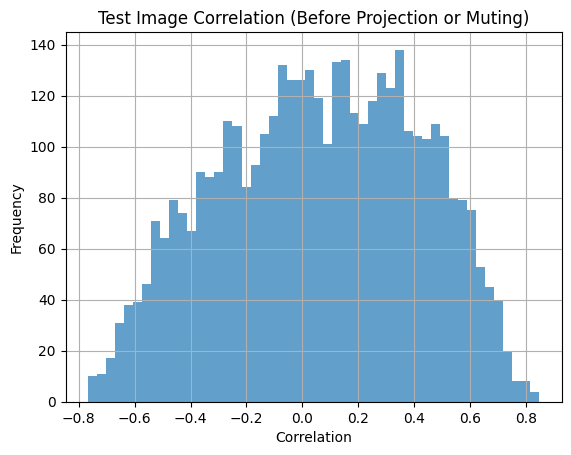

Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Number of neurons: 8000
Number of test patch images: 100
Number of test no-patch images: 100


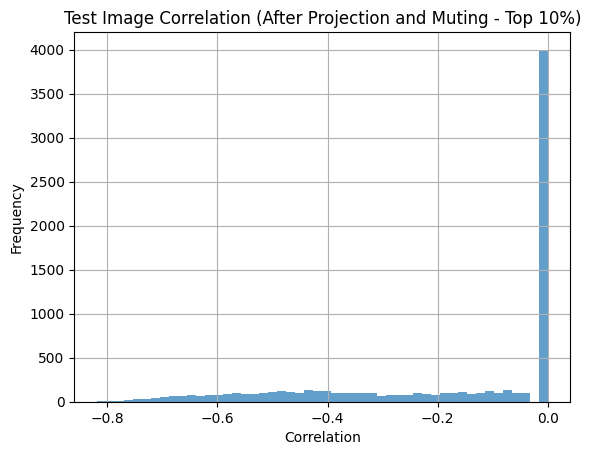

Number of neurons: 4000
Number of test patch images: 100
Number of test no-patch images: 100


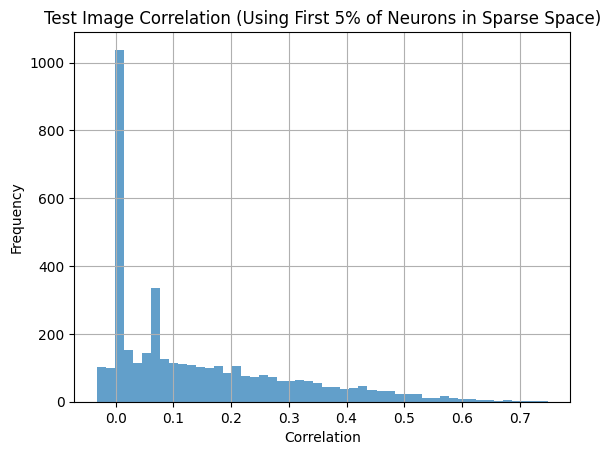

In [ ]:
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import mean_squared_error


def calculate_reconstruction_error(original_activations, decoded_activations):
    """
    Calculate the reconstruction error as mean squared error (MSE).
    """
    mse = mean_squared_error(original_activations, decoded_activations)
    return mse



def plot_correlation_histogram(original, projected, title):
    correlations = [
        np.corrcoef(original[:, i], projected[:, i])[0, 1]
        if np.std(original[:, i]) > 0 and np.std(projected[:, i]) > 0
        else 0  # Handle constant features
        for i in range(original.shape[1])
    ]
    correlations = np.nan_to_num(correlations)  # Replace NaNs with 0
    plt.hist(correlations, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("Correlation")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()



# Function 12 to classify decoded activations
def classify_decoded_activations(model, decoded_activations):
    """Classify decoded activations using the softmax layer of the model."""
    predictions = []
    for activation in decoded_activations:
        # Convert numpy activation to a tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)

        # Pass through classifier[5] (ReLU)
        relu_output = model.classifier[5](activation_tensor)

        # Pass through classifier[6] (final linear layer)
        output = model.classifier[6](relu_output)

        # Apply softmax and get the predicted class
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)

    return predictions


# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Save all neuron differences and indexes in descending order
def save_all_neurons_to_csv(abs_diff, folder_name, filename="all_neuron_differences_200.csv"):
    """
    Save all neuron indexes sorted by their differences (descending order) to a CSV file.
    """
    print(f"Saving all neuron differences to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

    return csv_path # return the csv_path


def save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename="neurons_by_correlation_200.csv"):
    os.makedirs(folder_name, exist_ok=True)

    # Number of neurons should be 16k
    num_neurons = val_patch_activations.shape[1]
    print(f"Number of val patch neurons: {num_neurons}")
    num_images = val_patch_activations.shape[0]
    print(f"Number of val patch images: {val_patch_activations.shape[0]}")

    # Create a binary label vector pp (1 for patch, 0 for no patch)
    pp = np.concatenate([np.ones(val_patch_activations.shape[0]), np.zeros(val_no_patch_activations.shape[0])])
    print(f"Number of pp labels: {len(pp)}")

    # array to store correlations
    correlations = np.zeros(num_neurons)

    for i in range(num_neurons):
        # Combine activations for neuron i from both datassets p and np
        act_i = np.concatenate([val_patch_activations[:, i], val_no_patch_activations[:, i]])

        # Compute correlation between pp and act_i
        if np.std(pp) > 0 and np.std(act_i) > 0:
            corr = np.corrcoef(pp, act_i)[0, 1]
        else:
            corr = 0  # Handle constant vectors

        correlations[i] = corr

    # As previous code
    # Handle NaN correlations (replace NaN with 0)
    correlations = np.nan_to_num(correlations)
    print('shape of correlations', correlations.shape)

    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(num_neurons),
        "Correlation": correlations
    })

    # Sort by correlation in descending order
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"Neuron correlations saved at: {csv_path}")

    return csv_path



def save_top_neurons_to_csv(abs_diff, top_neurons, folder_name, filename="top_neurons.csv"):
    """
    Save the top neurons with their difference values to a CSV file.
    """
    print(f"Saving top neurons to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": range(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Mark whether each neuron is in the top 10%
    neuron_data["Selected_for_Muting"] = neuron_data["Neuron_Index"].isin(top_neurons)

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

# Function to load top neurons from CSV based on a percentage
def load_top_neurons_from_csv(folder_name, filename, percentage):
    """
    Load top neurons based on the specified percentage from the saved CSV file.
    """
    csv_path = os.path.join(folder_name, filename)
    neuron_data = pd.read_csv(csv_path)

    # Calculate the number of top neurons to select
    top_count = int(len(neuron_data) * (percentage / 100))

    # Select the top neurons based on their activation difference
    top_neurons = neuron_data.iloc[:top_count]["Neuron_Index"].values

    # Debugging for 0% muting
    if percentage == 0:
        assert len(top_neurons) == 0, "Top neurons list should be empty for 0% muting."

    print(f"Loaded top {percentage}% neurons ({top_count} neurons) for muting.")
    return top_neurons


def classify_with_alexnet(model, activations):
    """
    Classify images using the original AlexNet classifier on the fc2 activations.
    """
    model.eval() #TAKE A LOOK HERE!!!!!
    predictions = []
    for activation in activations:
        # Convert numpy activation to tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)
        relu_output = model.classifier[5](activation_tensor)  # Apply ReLU
        output = model.classifier[6](relu_output)  # Apply fc3
        prediction = torch.argmax(output).item()
        #prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item() #TAKE A LOOK HERE!!!!!
        predictions.append(prediction)
    return predictions

# Function to calculate accuracy per group
def calculate_group_accuracy(predictions, true_labels):
    return accuracy_score(true_labels, predictions)

'''
def main():

    seeds = [1, 11, 111, 1111, 11111, 111111, 1111111] #!!!!!!!!

    # Paths to models, activations, and autoencoders for each seed
    model_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"
        for seed in seeds
    ]
    autoencoder_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_{seed}.pth"
        for seed in seeds
    ]
    test_activation_malignant_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_malignant_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_patch_200_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_no_patch_200_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]

    # Output folder for results
    folder_name = "/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic"
    os.makedirs(folder_name, exist_ok=True)

    # Prepare a DataFrame to store results
    results_df = pd.DataFrame(columns=[
        "Seed", "Percentage",
        "Val_Patch_Before", "Val_NoPatch_Before",
        "Val_Patch_After", "Val_NoPatch_After",
        "Test_Malignant_Patch_Before", "Test_Malignant_NoPatch_Before",
        "Test_Malignant_Patch_After", "Test_Malignant_NoPatch_After",
        "Test_Benign_Patch_Before", "Test_Benign_NoPatch_Before",
        "Test_Benign_Patch_After", "Test_Benign_NoPatch_After",
        "Worst_Acc_Before", "Worst_Acc_After",
        "Avg_Acc_Before", "Avg_Acc_After"
    ])

    # Loop through seeds/models/autoencoders
    for seed_idx, seed in enumerate(seeds):
        print(f"\nProcessing Seed {seed}")

        # Load paths
        model_path = model_paths[seed_idx]
        sae_path = autoencoder_paths[seed_idx]
        val_patch_path = val_activation_patch_paths[seed_idx]
        val_no_patch_path = val_activation_no_patch_paths[seed_idx]
        test_malignant_patch_path = test_activation_malignant_patch_paths[seed_idx]
        test_malignant_no_patch_path = test_activation_malignant_no_patch_paths[seed_idx]
        test_benign_patch_path = test_activation_benign_patch_paths[seed_idx]
        test_benign_no_patch_path = test_activation_benign_no_patch_paths[seed_idx]

        # Load the model and autoencoder
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)
        autoencoder = load_autoencoder(device, sae_path)

        # Load pre-saved activations
        val_activations_patch = np.load(val_patch_path, allow_pickle=True)
        val_activations_no_patch = np.load(val_no_patch_path, allow_pickle=True)

        test_malignant_patch = np.load(test_malignant_patch_path, allow_pickle=True)
        test_malignant_no_patch = np.load(test_malignant_no_patch_path, allow_pickle=True)
        test_benign_patch = np.load(test_benign_patch_path, allow_pickle=True)
        test_benign_no_patch = np.load(test_benign_no_patch_path, allow_pickle=True)

        # Classify "before muting"
        predictions_val_patch_before = classify_with_alexnet(model, val_activations_patch)
        predictions_val_no_patch_before = classify_with_alexnet(model, val_activations_no_patch)
        accuracy_val_patch_before = calculate_group_accuracy(predictions_val_patch_before, [0] * len(predictions_val_patch_before))
        accuracy_val_no_patch_before = calculate_group_accuracy(predictions_val_no_patch_before, [0] * len(predictions_val_no_patch_before))

        predictions_test_malignant_patch_before = classify_with_alexnet(model, test_malignant_patch)
        predictions_test_malignant_no_patch_before = classify_with_alexnet(model, test_malignant_no_patch)
        predictions_test_benign_patch_before = classify_with_alexnet(model, test_benign_patch)
        predictions_test_benign_no_patch_before = classify_with_alexnet(model, test_benign_no_patch)

        accuracy_test_malignant_patch_before = calculate_group_accuracy(predictions_test_malignant_patch_before, [1] * len(predictions_test_malignant_patch_before))
        accuracy_test_malignant_no_patch_before = calculate_group_accuracy(predictions_test_malignant_no_patch_before, [1] * len(predictions_test_malignant_no_patch_before))
        accuracy_test_benign_patch_before = calculate_group_accuracy(predictions_test_benign_patch_before, [0] * len(predictions_test_benign_patch_before))
        accuracy_test_benign_no_patch_before = calculate_group_accuracy(predictions_test_benign_no_patch_before, [0] * len(predictions_test_benign_no_patch_before))

        # Project activations
        projected_val_patch = project_activations(autoencoder, val_activations_patch, device)
        projected_val_no_patch = project_activations(autoencoder, val_activations_no_patch, device)
        projected_malignant_test_patch = project_activations(autoencoder, test_malignant_patch, device)
        projected_malignant_test_no_patch = project_activations(autoencoder, test_malignant_no_patch, device)
        projected_benign_test_patch = project_activations(autoencoder, test_benign_patch, device)
        projected_benign_test_no_patch = project_activations(autoencoder, test_benign_no_patch, device)


        # Loop through percentages
        for percentage in range(0, 51):  # 1% to 25%
            print(f"Testing with {percentage}% muting...")

            if percentage == 0:
                # Decode original activations without muting
                decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch).to(device).float()).cpu().numpy()
                decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch).to(device).float()).cpu().numpy()
                decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch).to(device).float()).cpu().numpy()
                decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch).to(device).float()).cpu().numpy()
                decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch).to(device).float()).cpu().numpy()
                decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch).to(device).float()).cpu().numpy()

                # Calculate reconstruction errors
                recon_error_val_patch = calculate_reconstruction_error(val_activations_patch, decoded_val_patch)
                recon_error_val_no_patch = calculate_reconstruction_error(val_activations_no_patch, decoded_val_no_patch)
                recon_error_test_malignant_patch = calculate_reconstruction_error(test_malignant_patch, decoded_malignant_test_patch)
                recon_error_test_malignant_no_patch = calculate_reconstruction_error(test_malignant_no_patch, decoded_malignant_test_no_patch)
                recon_error_test_benign_patch = calculate_reconstruction_error(test_benign_patch, decoded_benign_test_patch)
                recon_error_test_benign_no_patch = calculate_reconstruction_error(test_benign_no_patch, decoded_benign_test_no_patch)

                # Print reconstruction errors
                print(f"Reconstruction Error (Val Patch): {recon_error_val_patch:.4f}")
                print(f"Reconstruction Error (Val No Patch): {recon_error_val_no_patch:.4f}")
                print(f"Reconstruction Error (Test Malignant Patch): {recon_error_test_malignant_patch:.4f}")
                print(f"Reconstruction Error (Test Malignant No Patch): {recon_error_test_malignant_no_patch:.4f}")
                print(f"Reconstruction Error (Test Benign Patch): {recon_error_test_benign_patch:.4f}")
                print(f"Reconstruction Error (Test Benign No Patch): {recon_error_test_benign_no_patch:.4f}")



            # Calculate differences and load top neurons
            #abs_diff = np.abs(np.mean(projected_val_patch, axis=0) - np.mean(projected_val_no_patch, axis=0))
            #csv_path = save_all_neurons_to_csv(abs_diff, folder_name, filename=f"mnist_fg_val_neuron_differences_seed_{seed}.csv")
            #top_neurons = load_top_neurons_from_csv(folder_name, f"mnist_fg_val_neuron_differences_seed_{seed}.csv", percentage)

            # **Correlation-Based Neurons**
            correlation_csv_path = save_neurons_by_correlation(
                projected_val_patch, projected_val_no_patch, folder_name, filename=f"l1_neurons_by_correlation_seed_{seed}_200.csv"
            )
            top_neurons_corr = load_top_neurons_from_csv(folder_name, f"l1_neurons_by_correlation_seed_{seed}_200.csv", percentage)

            top_neurons = top_neurons_corr

            # Muting neurons
            projected_val_patch_muted = projected_val_patch.copy()
            projected_val_no_patch_muted = projected_val_no_patch.copy()
            projected_malignant_test_patch_muted = projected_malignant_test_patch.copy()
            projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.copy()
            projected_benign_test_patch_muted = projected_benign_test_patch.copy()
            projected_benign_test_no_patch_muted = projected_benign_test_no_patch.copy()

            projected_val_patch_muted[:, top_neurons] = 0
            projected_val_no_patch_muted[:, top_neurons] = 0
            projected_malignant_test_patch_muted[:, top_neurons] = 0
            projected_malignant_test_no_patch_muted[:, top_neurons] = 0
            projected_benign_test_patch_muted[:, top_neurons] = 0
            projected_benign_test_no_patch_muted[:, top_neurons] = 0

            # Decode and classify
            decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch_muted).to(device).float()).cpu().numpy()
            decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch_muted).to(device).float()).cpu().numpy()

            predictions_val_patch_after = classify_decoded_activations(model, decoded_val_patch)
            predictions_val_no_patch_after = classify_decoded_activations(model, decoded_val_no_patch)
            predictions_test_malignant_patch_after = classify_decoded_activations(model, decoded_malignant_test_patch)
            predictions_test_malignant_no_patch_after = classify_decoded_activations(model, decoded_malignant_test_no_patch)
            predictions_test_benign_patch_after = classify_decoded_activations(model, decoded_benign_test_patch)
            predictions_test_benign_no_patch_after = classify_decoded_activations(model, decoded_benign_test_no_patch)

            accuracy_val_patch_after = calculate_group_accuracy(predictions_val_patch_after, [0] * len(predictions_val_patch_after))
            accuracy_val_no_patch_after = calculate_group_accuracy(predictions_val_no_patch_after, [0] * len(predictions_val_no_patch_after))
            accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
            accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
            accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
            accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))

            # Calculate worst and average group accuracies
            worst_acc_before = min(accuracy_test_malignant_patch_before, accuracy_test_malignant_no_patch_before)
            worst_acc_after = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after)
            avg_acc_before = (accuracy_test_malignant_patch_before + accuracy_test_malignant_no_patch_before +
                              accuracy_test_benign_patch_before + accuracy_test_benign_no_patch_before) / 4
            avg_acc_after = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after +
                             accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4

            # Append results to DataFrame
            new_row = pd.DataFrame([{
                "Seed": seed,
                "Percentage": percentage,
                "Val_Patch_Before": accuracy_val_patch_before,
                "Val_NoPatch_Before": accuracy_val_no_patch_before,
                "Val_Patch_After": accuracy_val_patch_after,
                "Val_NoPatch_After": accuracy_val_no_patch_after,
                "Test_Malignant_Patch_Before": accuracy_test_malignant_patch_before,
                "Test_Malignant_NoPatch_Before": accuracy_test_malignant_no_patch_before,
                "Test_Malignant_Patch_After": accuracy_test_malignant_patch_after,
                "Test_Malignant_NoPatch_After": accuracy_test_malignant_no_patch_after,
                "Test_Benign_Patch_Before": accuracy_test_benign_patch_before,
                "Test_Benign_NoPatch_Before": accuracy_test_benign_no_patch_before,
                "Test_Benign_Patch_After": accuracy_test_benign_patch_after,
                "Test_Benign_NoPatch_After": accuracy_test_benign_no_patch_after,
                "Worst_Acc_Before": worst_acc_before,
                "Worst_Acc_After": worst_acc_after,
                "Avg_Acc_Before": avg_acc_before,
                "Avg_Acc_After": avg_acc_after
            }])

            # Save results to CSV
            results_df = pd.concat([results_df, new_row], ignore_index=True)
    results_csv_path = os.path.join(folder_name, "isic_200.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"All results saved to {results_csv_path}")

if __name__ == "__main__":
    main()
'''

######################
def compute_and_plot_correlations(test_patch_activations, test_no_patch_activations, title):
    """
    Compute correlations using a binary label vector and plot the histogram.
    """
    # Number of neurons and images
    num_neurons = test_patch_activations.shape[1]
    num_images_patch = test_patch_activations.shape[0]
    num_images_no_patch = test_no_patch_activations.shape[0]

    print(f"Number of neurons: {num_neurons}")
    print(f"Number of test patch images: {num_images_patch}")
    print(f"Number of test no-patch images: {num_images_no_patch}")

    # Create a binary label vector (1 for patch, 0 for no patch)
    binary_labels = np.concatenate([np.ones(num_images_patch), np.zeros(num_images_no_patch)])

    # Compute correlations
    correlations = np.zeros(num_neurons)
    for i in range(num_neurons):
        # Combine activations for neuron i from both datasets
        combined_activations = np.concatenate([test_patch_activations[:, i], test_no_patch_activations[:, i]])

        # Compute correlation between binary labels and activations for neuron i
        if np.std(binary_labels) > 0 and np.std(combined_activations) > 0:
            correlations[i] = np.corrcoef(binary_labels, combined_activations)[0, 1]
        else:
            correlations[i] = 0  # Handle constant features

    correlations = np.nan_to_num(correlations)  # Replace NaN values with 0

    # Plot histogram
    plt.hist(correlations, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("Correlation")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    return correlations


# Load the pre-trained autoencoder for layer 6 (fc2)
def load_autoencoder(device, save_sae_dir):

    input_dims = 4096
    encoding_dim = 8000

    # Initialize the autoencoder
    autoencoder = SparseAutoencoder(input_dims, encoding_dim)
    autoencoder.load_state_dict(torch.load(save_sae_dir))
    autoencoder = autoencoder.to(device)

    # Freeze all parameters of the autoencoder
    for param in autoencoder.parameters():
        param.requires_grad = False

    # Set the autoencoder to evaluation mode
    autoencoder.eval()
    print(f"Autoencoder loaded from {save_sae_dir} and frozen successfully.")
    return autoencoder



def plot_correlation_for_scenarios_v2(
    autoencoder, test_patch, test_no_patch, device, top_neurons_10, top_neurons_5):
    """
    Generate and plot correlations for three scenarios, using a binary label correlation approach.
    """
    # 1. Before projection or muting
    compute_and_plot_correlations(
        test_patch, test_no_patch,
        "Test Image Correlation (Before Projection or Muting)"
    )

    # 2. After projection and muting (top 10% neurons)
    projected_patch = project_activations(autoencoder, test_patch, device)
    projected_no_patch = project_activations(autoencoder, test_no_patch, device)

    # Muting the top 10% neurons
    muted_patch = projected_patch.copy()
    muted_no_patch = projected_no_patch.copy()
    muted_patch[:, top_neurons_10] = 0
    muted_no_patch[:, top_neurons_10] = 0

    compute_and_plot_correlations(
        muted_patch, muted_no_patch,
        "Test Image Correlation (After Projection and Muting - Top 10%)"
    )

    # 3. Using only the first 5% of neurons in sparse space
    sparse_patch = projected_patch[:, top_neurons_5]
    sparse_no_patch = projected_no_patch[:, top_neurons_5]

    compute_and_plot_correlations(
        sparse_patch, sparse_no_patch,
        "Test Image Correlation (Using First 5% of Neurons in Sparse Space)"
    )


def main_with_updated_plots():
    seeds = [111]  # Seed values
    # Paths setup
    autoencoder_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_{seed}.pth"
        for seed in seeds
    ]
    test_activation_malignant_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_malignant_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    folder_name = "/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic"

    for seed_idx, seed in enumerate(seeds):
        print(f"\nProcessing Seed {seed}")

        # Load autoencoder
        autoencoder_path = autoencoder_paths[seed_idx]
        autoencoder = load_autoencoder(device, autoencoder_path)

        # Load activations
        test_patch = np.load(test_activation_malignant_patch_paths[seed_idx], allow_pickle=True)
        test_no_patch = np.load(test_activation_malignant_no_patch_paths[seed_idx], allow_pickle=True)

        # Project activations
        projected_test_patch = project_activations(autoencoder, test_patch, device)
        projected_test_no_patch = project_activations(autoencoder, test_no_patch, device)

        # Save and load top neurons
        correlation_csv_path = save_neurons_by_correlation(
            projected_test_patch, projected_test_no_patch, folder_name,
            filename=f"l1_neurons_by_correlation_seed_{seed}_200.csv"
        )
        top_neurons_10 = load_top_neurons_from_csv(
            folder_name, f"l1_neurons_by_correlation_seed_{seed}_200.csv", percentage=50
        )
        top_neurons_5 = load_top_neurons_from_csv(
            folder_name, f"l1_neurons_by_correlation_seed_{seed}_200.csv", percentage=50
        )

        # Generate correlation plots
        plot_correlation_for_scenarios_v2(
            autoencoder, test_patch, test_no_patch, device, top_neurons_10, top_neurons_5
        )

#if __name__ == "__main__":
#    main_with_updated_plots()

### 100

In [ ]:
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import mean_squared_error


def calculate_reconstruction_error(original_activations, decoded_activations):
    """
    Calculate the reconstruction error as mean squared error (MSE).
    """
    mse = mean_squared_error(original_activations, decoded_activations)
    return mse



def plot_correlation_histogram(original, projected, title):
    correlations = [
        np.corrcoef(original[:, i], projected[:, i])[0, 1]
        if np.std(original[:, i]) > 0 and np.std(projected[:, i]) > 0
        else 0  # Handle constant features
        for i in range(original.shape[1])
    ]
    correlations = np.nan_to_num(correlations)  # Replace NaNs with 0
    plt.hist(correlations, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("Correlation")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()



# Function 12 to classify decoded activations
def classify_decoded_activations(model, decoded_activations):
    """Classify decoded activations using the softmax layer of the model."""
    predictions = []
    for activation in decoded_activations:
        # Convert numpy activation to a tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)

        # Pass through classifier[5] (ReLU)
        relu_output = model.classifier[5](activation_tensor)

        # Pass through classifier[6] (final linear layer)
        output = model.classifier[6](relu_output)

        # Apply softmax and get the predicted class
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)

    return predictions


# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Save all neuron differences and indexes in descending order
def save_all_neurons_to_csv(abs_diff, folder_name, filename="all_neuron_differences_100.csv"):
    """
    Save all neuron indexes sorted by their differences (descending order) to a CSV file.
    """
    print(f"Saving all neuron differences to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

    return csv_path # return the csv_path
'''
def save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename="neurons_by_correlation.csv"):
    """
    Save neurons sorted by their correlation between val_patch_activations and val_no_patch_activations.
    """
    print(f"Calculating neuron correlations and saving to {filename}")

    # Compute the correlation for each neuron across the two groups
    correlations = np.array([
        np.corrcoef(val_patch_activations[:, i], val_no_patch_activations[:, i])[0, 1]
        if np.std(val_patch_activations[:, i]) > 0 and np.std(val_no_patch_activations[:, i]) > 0
        else 0  # Set correlation to 0 if one group has constant values
        for i in range(val_patch_activations.shape[1])
    ])

    # Handle NaN correlations (replace NaN with 0)
    correlations = np.nan_to_num(correlations)

    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(correlations)),
        "Correlation": correlations
    })

    # Sort by absolute correlation in ascending order (low correlation first)
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"Neuron correlations saved at: {csv_path}")

    return csv_path

'''

def save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename="neurons_by_correlation_100.csv"):
    os.makedirs(folder_name, exist_ok=True)

    # Number of neurons should be 16k
    num_neurons = val_patch_activations.shape[1]
    print(f"Number of val patch neurons: {num_neurons}")
    num_images = val_patch_activations.shape[0]
    print(f"Number of val patch images: {val_patch_activations.shape[0]}")

    # Create a binary label vector pp (1 for patch, 0 for no patch)
    pp = np.concatenate([np.ones(val_patch_activations.shape[0]), np.zeros(val_no_patch_activations.shape[0])])
    print(f"Number of pp labels: {len(pp)}")

    # array to store correlations
    correlations = np.zeros(num_neurons)

    for i in range(num_neurons):
        # Combine activations for neuron i from both datassets p and np
        act_i = np.concatenate([val_patch_activations[:, i], val_no_patch_activations[:, i]])

        # Compute correlation between pp and act_i
        if np.std(pp) > 0 and np.std(act_i) > 0:
            corr = np.corrcoef(pp, act_i)[0, 1]
        else:
            corr = 0  # Handle constant vectors

        correlations[i] = corr

    # As previous code
    # Handle NaN correlations (replace NaN with 0)
    correlations = np.nan_to_num(correlations)
    print('shape of correlations', correlations.shape)

    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(num_neurons),
        "Correlation": correlations
    })

    # Sort by correlation in descending order
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"Neuron correlations saved at: {csv_path}")

    return csv_path


def save_top_neurons_to_csv(abs_diff, top_neurons, folder_name, filename="top_neurons_100.csv"):
    """
    Save the top neurons with their difference values to a CSV file.
    """
    print(f"Saving top neurons to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": range(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Mark whether each neuron is in the top 10%
    neuron_data["Selected_for_Muting"] = neuron_data["Neuron_Index"].isin(top_neurons)

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

# Function to load top neurons from CSV based on a percentage
def load_top_neurons_from_csv(folder_name, filename, percentage):
    """
    Load top neurons based on the specified percentage from the saved CSV file.
    """
    csv_path = os.path.join(folder_name, filename)
    neuron_data = pd.read_csv(csv_path)

    # Calculate the number of top neurons to select
    top_count = int(len(neuron_data) * (percentage / 100))

    # Select the top neurons based on their activation difference
    top_neurons = neuron_data.iloc[:top_count]["Neuron_Index"].values

    # Debugging for 0% muting
    if percentage == 0:
        assert len(top_neurons) == 0, "Top neurons list should be empty for 0% muting."

    print(f"Loaded top {percentage}% neurons ({top_count} neurons) for muting.")
    return top_neurons


def classify_with_alexnet(model, activations):
    """
    Classify images using the original AlexNet classifier on the fc2 activations.
    """
    model.eval() #TAKE A LOOK HERE!!!!!
    predictions = []
    for activation in activations:
        # Convert numpy activation to tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)
        relu_output = model.classifier[5](activation_tensor)  # Apply ReLU
        output = model.classifier[6](relu_output)  # Apply fc3
        prediction = torch.argmax(output).item()
        #prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item() #TAKE A LOOK HERE!!!!!
        predictions.append(prediction)
    return predictions

# Function to calculate accuracy per group
def calculate_group_accuracy(predictions, true_labels):
    return accuracy_score(true_labels, predictions)


def main():

    seeds = [1, 11, 111, 1111, 11111, 111111, 1111111]

    # Paths to models, activations, and autoencoders for each seed
    model_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"
        for seed in seeds
    ]
    autoencoder_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_{seed}.pth"
        for seed in seeds
    ]
    test_activation_malignant_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_malignant_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]

    # Output folder for results
    folder_name = "/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic"
    os.makedirs(folder_name, exist_ok=True)

    # Prepare a DataFrame to store results
    results_df = pd.DataFrame(columns=[
        "Seed", "Percentage",
        "Val_Patch_Before", "Val_NoPatch_Before",
        "Val_Patch_After", "Val_NoPatch_After",
        "Test_Malignant_Patch_Before", "Test_Malignant_NoPatch_Before",
        "Test_Malignant_Patch_After", "Test_Malignant_NoPatch_After",
        "Test_Benign_Patch_Before", "Test_Benign_NoPatch_Before",
        "Test_Benign_Patch_After", "Test_Benign_NoPatch_After",
        "Worst_Acc_Before", "Worst_Acc_After",
        "Avg_Acc_Before", "Avg_Acc_After"
    ])

    # Loop through seeds/models/autoencoders
    for seed_idx, seed in enumerate(seeds):
        print(f"\nProcessing Seed {seed}")

        # Load paths
        model_path = model_paths[seed_idx]
        sae_path = autoencoder_paths[seed_idx]
        val_patch_path = val_activation_patch_paths[seed_idx]
        val_no_patch_path = val_activation_no_patch_paths[seed_idx]
        test_malignant_patch_path = test_activation_malignant_patch_paths[seed_idx]
        test_malignant_no_patch_path = test_activation_malignant_no_patch_paths[seed_idx]
        test_benign_patch_path = test_activation_benign_patch_paths[seed_idx]
        test_benign_no_patch_path = test_activation_benign_no_patch_paths[seed_idx]

        # Load the model and autoencoder
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)
        autoencoder = load_autoencoder(device, sae_path)

        # Load pre-saved activations
        val_activations_patch = np.load(val_patch_path, allow_pickle=True)
        val_activations_no_patch = np.load(val_no_patch_path, allow_pickle=True)

        test_malignant_patch = np.load(test_malignant_patch_path, allow_pickle=True)
        test_malignant_no_patch = np.load(test_malignant_no_patch_path, allow_pickle=True)
        test_benign_patch = np.load(test_benign_patch_path, allow_pickle=True)
        test_benign_no_patch = np.load(test_benign_no_patch_path, allow_pickle=True)

        # Classify "before muting"
        predictions_val_patch_before = classify_with_alexnet(model, val_activations_patch)
        predictions_val_no_patch_before = classify_with_alexnet(model, val_activations_no_patch)
        accuracy_val_patch_before = calculate_group_accuracy(predictions_val_patch_before, [0] * len(predictions_val_patch_before))
        accuracy_val_no_patch_before = calculate_group_accuracy(predictions_val_no_patch_before, [0] * len(predictions_val_no_patch_before))

        predictions_test_malignant_patch_before = classify_with_alexnet(model, test_malignant_patch)
        predictions_test_malignant_no_patch_before = classify_with_alexnet(model, test_malignant_no_patch)
        predictions_test_benign_patch_before = classify_with_alexnet(model, test_benign_patch)
        predictions_test_benign_no_patch_before = classify_with_alexnet(model, test_benign_no_patch)

        accuracy_test_malignant_patch_before = calculate_group_accuracy(predictions_test_malignant_patch_before, [1] * len(predictions_test_malignant_patch_before))
        accuracy_test_malignant_no_patch_before = calculate_group_accuracy(predictions_test_malignant_no_patch_before, [1] * len(predictions_test_malignant_no_patch_before))
        accuracy_test_benign_patch_before = calculate_group_accuracy(predictions_test_benign_patch_before, [0] * len(predictions_test_benign_patch_before))
        accuracy_test_benign_no_patch_before = calculate_group_accuracy(predictions_test_benign_no_patch_before, [0] * len(predictions_test_benign_no_patch_before))

        # Project activations
        projected_val_patch = project_activations(autoencoder, val_activations_patch, device)
        projected_val_no_patch = project_activations(autoencoder, val_activations_no_patch, device)
        projected_malignant_test_patch = project_activations(autoencoder, test_malignant_patch, device)
        projected_malignant_test_no_patch = project_activations(autoencoder, test_malignant_no_patch, device)
        projected_benign_test_patch = project_activations(autoencoder, test_benign_patch, device)
        projected_benign_test_no_patch = project_activations(autoencoder, test_benign_no_patch, device)


        # Loop through percentages
        for percentage in range(0,51):  # 1% to 25%
            print(f"Testing with {percentage}% muting...")

            if percentage == 0:
                # Decode original activations without muting
                decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch).to(device).float()).cpu().numpy()
                decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch).to(device).float()).cpu().numpy()
                decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch).to(device).float()).cpu().numpy()
                decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch).to(device).float()).cpu().numpy()
                decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch).to(device).float()).cpu().numpy()
                decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch).to(device).float()).cpu().numpy()

                # Calculate reconstruction errors
                recon_error_val_patch = calculate_reconstruction_error(val_activations_patch, decoded_val_patch)
                recon_error_val_no_patch = calculate_reconstruction_error(val_activations_no_patch, decoded_val_no_patch)
                recon_error_test_malignant_patch = calculate_reconstruction_error(test_malignant_patch, decoded_malignant_test_patch)
                recon_error_test_malignant_no_patch = calculate_reconstruction_error(test_malignant_no_patch, decoded_malignant_test_no_patch)
                recon_error_test_benign_patch = calculate_reconstruction_error(test_benign_patch, decoded_benign_test_patch)
                recon_error_test_benign_no_patch = calculate_reconstruction_error(test_benign_no_patch, decoded_benign_test_no_patch)

                # Print reconstruction errors
                print(f"Reconstruction Error (Val Patch): {recon_error_val_patch:.4f}")
                print(f"Reconstruction Error (Val No Patch): {recon_error_val_no_patch:.4f}")
                print(f"Reconstruction Error (Test Malignant Patch): {recon_error_test_malignant_patch:.4f}")
                print(f"Reconstruction Error (Test Malignant No Patch): {recon_error_test_malignant_no_patch:.4f}")
                print(f"Reconstruction Error (Test Benign Patch): {recon_error_test_benign_patch:.4f}")
                print(f"Reconstruction Error (Test Benign No Patch): {recon_error_test_benign_no_patch:.4f}")



            # Calculate differences and load top neurons
            #abs_diff = np.abs(np.mean(projected_val_patch, axis=0) - np.mean(projected_val_no_patch, axis=0))
            #csv_path = save_all_neurons_to_csv(abs_diff, folder_name, filename=f"mnist_fg_val_neuron_differences_seed_{seed}.csv")
            #top_neurons = load_top_neurons_from_csv(folder_name, f"mnist_fg_val_neuron_differences_seed_{seed}.csv", percentage)

            # **Correlation-Based Neurons**
            correlation_csv_path = save_neurons_by_correlation(
                projected_val_patch, projected_val_no_patch, folder_name, filename=f"l1_neurons_by_correlation_seed_{seed}_100.csv"
            )
            top_neurons_corr = load_top_neurons_from_csv(folder_name, f"l1_neurons_by_correlation_seed_{seed}_100.csv", percentage)

            top_neurons = top_neurons_corr

            # Muting neurons
            projected_val_patch_muted = projected_val_patch.copy()
            projected_val_no_patch_muted = projected_val_no_patch.copy()
            projected_malignant_test_patch_muted = projected_malignant_test_patch.copy()
            projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.copy()
            projected_benign_test_patch_muted = projected_benign_test_patch.copy()
            projected_benign_test_no_patch_muted = projected_benign_test_no_patch.copy()

            projected_val_patch_muted[:, top_neurons] = 0
            projected_val_no_patch_muted[:, top_neurons] = 0
            projected_malignant_test_patch_muted[:, top_neurons] = 0
            projected_malignant_test_no_patch_muted[:, top_neurons] = 0
            projected_benign_test_patch_muted[:, top_neurons] = 0
            projected_benign_test_no_patch_muted[:, top_neurons] = 0

            # Decode and classify
            decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch_muted).to(device).float()).cpu().numpy()
            decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch_muted).to(device).float()).cpu().numpy()

            predictions_val_patch_after = classify_decoded_activations(model, decoded_val_patch)
            predictions_val_no_patch_after = classify_decoded_activations(model, decoded_val_no_patch)
            predictions_test_malignant_patch_after = classify_decoded_activations(model, decoded_malignant_test_patch)
            predictions_test_malignant_no_patch_after = classify_decoded_activations(model, decoded_malignant_test_no_patch)
            predictions_test_benign_patch_after = classify_decoded_activations(model, decoded_benign_test_patch)
            predictions_test_benign_no_patch_after = classify_decoded_activations(model, decoded_benign_test_no_patch)

            accuracy_val_patch_after = calculate_group_accuracy(predictions_val_patch_after, [0] * len(predictions_val_patch_after))
            accuracy_val_no_patch_after = calculate_group_accuracy(predictions_val_no_patch_after, [0] * len(predictions_val_no_patch_after))
            accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
            accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
            accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
            accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))

            # Calculate worst and average group accuracies
            worst_acc_before = min(accuracy_test_malignant_patch_before, accuracy_test_malignant_no_patch_before)
            worst_acc_after = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after)
            avg_acc_before = (accuracy_test_malignant_patch_before + accuracy_test_malignant_no_patch_before +
                              accuracy_test_benign_patch_before + accuracy_test_benign_no_patch_before) / 4
            avg_acc_after = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after +
                             accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4

            # Append results to DataFrame
            new_row = pd.DataFrame([{
                "Seed": seed,
                "Percentage": percentage,
                "Val_Patch_Before": accuracy_val_patch_before,
                "Val_NoPatch_Before": accuracy_val_no_patch_before,
                "Val_Patch_After": accuracy_val_patch_after,
                "Val_NoPatch_After": accuracy_val_no_patch_after,
                "Test_Malignant_Patch_Before": accuracy_test_malignant_patch_before,
                "Test_Malignant_NoPatch_Before": accuracy_test_malignant_no_patch_before,
                "Test_Malignant_Patch_After": accuracy_test_malignant_patch_after,
                "Test_Malignant_NoPatch_After": accuracy_test_malignant_no_patch_after,
                "Test_Benign_Patch_Before": accuracy_test_benign_patch_before,
                "Test_Benign_NoPatch_Before": accuracy_test_benign_no_patch_before,
                "Test_Benign_Patch_After": accuracy_test_benign_patch_after,
                "Test_Benign_NoPatch_After": accuracy_test_benign_no_patch_after,
                "Worst_Acc_Before": worst_acc_before,
                "Worst_Acc_After": worst_acc_after,
                "Avg_Acc_Before": avg_acc_before,
                "Avg_Acc_After": avg_acc_after
            }])

            # Save results to CSV
            results_df = pd.concat([results_df, new_row], ignore_index=True)
    results_csv_path = os.path.join(folder_name, "isic_100.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"All results saved to {results_csv_path}")

if __name__ == "__main__":
    main()





def compute_and_plot_correlations(test_patch_activations, test_no_patch_activations, title):
    """
    Compute correlations using a binary label vector and plot the histogram.
    """
    # Number of neurons and images
    num_neurons = test_patch_activations.shape[1]
    num_images_patch = test_patch_activations.shape[0]
    num_images_no_patch = test_no_patch_activations.shape[0]

    print(f"Number of neurons: {num_neurons}")
    print(f"Number of test patch images: {num_images_patch}")
    print(f"Number of test no-patch images: {num_images_no_patch}")

    # Create a binary label vector (1 for patch, 0 for no patch)
    binary_labels = np.concatenate([np.ones(num_images_patch), np.zeros(num_images_no_patch)])

    # Compute correlations
    correlations = np.zeros(num_neurons)
    for i in range(num_neurons):
        # Combine activations for neuron i from both datasets
        combined_activations = np.concatenate([test_patch_activations[:, i], test_no_patch_activations[:, i]])

        # Compute correlation between binary labels and activations for neuron i
        if np.std(binary_labels) > 0 and np.std(combined_activations) > 0:
            correlations[i] = np.corrcoef(binary_labels, combined_activations)[0, 1]
        else:
            correlations[i] = 0  # Handle constant features

    correlations = np.nan_to_num(correlations)  # Replace NaN values with 0

    # Plot histogram
    plt.hist(correlations, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("Correlation")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    return correlations


def plot_correlation_for_scenarios_v2(
    autoencoder, test_patch, test_no_patch, device, top_neurons_10, top_neurons_5):
    """
    Generate and plot correlations for three scenarios, using a binary label correlation approach.
    """
    # 1. Before projection or muting
    compute_and_plot_correlations(
        test_patch, test_no_patch,
        "Test Image Correlation (Before Projection or Muting)"
    )

    # 2. After projection and muting (top 10% neurons)
    projected_patch = project_activations(autoencoder, test_patch, device)
    projected_no_patch = project_activations(autoencoder, test_no_patch, device)

    # Muting the top 10% neurons
    muted_patch = projected_patch.copy()
    muted_no_patch = projected_no_patch.copy()
    muted_patch[:, top_neurons_10] = 0
    muted_no_patch[:, top_neurons_10] = 0

    compute_and_plot_correlations(
        muted_patch, muted_no_patch,
        "Test Image Correlation (After Projection and Muting - Top 10%)"
    )

    # 3. Using only the first 5% of neurons in sparse space
    sparse_patch = projected_patch[:, top_neurons_5]
    sparse_no_patch = projected_no_patch[:, top_neurons_5]

    compute_and_plot_correlations(
        sparse_patch, sparse_no_patch,
        "Test Image Correlation (Using First 5% of Neurons in Sparse Space)"
    )


def main_with_updated_plots():
    seeds = [1, 11, 111, 1111, 11111, 111111, 1111111]  # Seed values

    for seed_idx, seed in enumerate(seeds):
        print(f"\nProcessing Seed {seed}")

        # Load autoencoder and activations
        autoencoder = load_autoencoder(device, sae_path)
        test_patch = np.load(test_activation_malignant_patch_path, allow_pickle=True)
        test_no_patch = np.load(test_activation_malignant_no_patch_path, allow_pickle=True)

        # Project activations
        projected_test_patch = project_activations(autoencoder, test_patch, device)
        projected_test_no_patch = project_activations(autoencoder, test_no_patch, device)

        # Load top 10% and 5% neurons
        correlation_csv_path = save_neurons_by_correlation(
            projected_test_patch, projected_test_no_patch, folder_name,
            filename=f"l1_neurons_by_correlation_seed_{seed}_200.csv"
        )
        top_neurons_10 = load_top_neurons_from_csv(
            folder_name, f"l1_neurons_by_correlation_seed_{seed}_200.csv", percentage=10
        )
        top_neurons_5 = load_top_neurons_from_csv(
            folder_name, f"l1_neurons_by_correlation_seed_{seed}_200.csv", percentage=5
        )

        # Generate correlation plots
        plot_correlation_for_scenarios_v2(
            autoencoder, test_patch, test_no_patch, device, top_neurons_10, top_neurons_5
        )


if __name__ == "__main__":
    main_with_updated_plots()



Processing Seed 1
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1.pt


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-13-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_1.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 20.4068
Reconstruction Error (Val No Patch): 27.0812
Reconstruction Error (Test Malignant Patch): 26.6600
Reconstruction Error (Test Malignant No Patch): 28.4344
Reconstruction Error (Test Benign Patch): 21.9674
Reconstruction Error (Test Benign No Patch): 24.7431
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDriv

<ipython-input-18-dfb9c53309b1>:454: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic/l1_neurons_by_correlation_seed_1_100.csv
Loaded top 1% neurons (80 neurons) for muting.
Testing with 2% muting...
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic/l1_neurons_by_correlation_seed_1_100.csv
Loaded top 2% neurons (160 neurons) for muting.
Testing with 3% muting...
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic/l1_neurons_by_correlation_seed_1_100.csv
Loaded top 3% neurons (240 neurons) for muting.
Testing with 4% muting...
Number of

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-13-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_11.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 20.2822
Reconstruction Error (Val No Patch): 26.7357
Reconstruction Error (Test Malignant Patch): 26.3760
Reconstruction Error (Test Malignant No Patch): 28.0654
Reconstruction Error (Test Benign Patch): 21.8447
Reconstruction Error (Test Benign No Patch): 24.4141
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDri

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-13-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 20.4730
Reconstruction Error (Val No Patch): 27.2059
Reconstruction Error (Test Malignant Patch): 26.7610
Reconstruction Error (Test Malignant No Patch): 28.5516
Reconstruction Error (Test Benign Patch): 22.0420
Reconstruction Error (Test Benign No Patch): 24.8511
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDr

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-13-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_1111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 20.5615
Reconstruction Error (Val No Patch): 27.2428
Reconstruction Error (Test Malignant Patch): 26.7946
Reconstruction Error (Test Malignant No Patch): 28.5417
Reconstruction Error (Test Benign Patch): 22.1321
Reconstruction Error (Test Benign No Patch): 24.8679
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyD

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-13-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_11111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 20.4142
Reconstruction Error (Val No Patch): 27.0095
Reconstruction Error (Test Malignant Patch): 26.6219
Reconstruction Error (Test Malignant No Patch): 28.3788
Reconstruction Error (Test Benign Patch): 21.9859
Reconstruction Error (Test Benign No Patch): 24.6676
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/My

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-13-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_111111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 20.4762
Reconstruction Error (Val No Patch): 27.0588
Reconstruction Error (Test Malignant Patch): 26.6334
Reconstruction Error (Test Malignant No Patch): 28.3462
Reconstruction Error (Test Benign Patch): 22.0395
Reconstruction Error (Test Benign No Patch): 24.7257
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/M

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-13-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_1111111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 20.5782
Reconstruction Error (Val No Patch): 27.2448
Reconstruction Error (Test Malignant Patch): 26.8849
Reconstruction Error (Test Malignant No Patch): 28.6097
Reconstruction Error (Test Benign Patch): 22.1553
Reconstruction Error (Test Benign No Patch): 24.8940
Number of val patch neurons: 8000
Number of val patch images: 100
Number of pp labels: 200
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/

NameError: name 'sae_path' is not defined

### 50

In [ ]:
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import mean_squared_error


def calculate_reconstruction_error(original_activations, decoded_activations):
    """
    Calculate the reconstruction error as mean squared error (MSE).
    """
    mse = mean_squared_error(original_activations, decoded_activations)
    return mse



def plot_correlation_histogram(original, projected, title):
    correlations = [
        np.corrcoef(original[:, i], projected[:, i])[0, 1]
        if np.std(original[:, i]) > 0 and np.std(projected[:, i]) > 0
        else 0  # Handle constant features
        for i in range(original.shape[1])
    ]
    correlations = np.nan_to_num(correlations)  # Replace NaNs with 0
    plt.hist(correlations, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("Correlation")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()



# Function 12 to classify decoded activations
def classify_decoded_activations(model, decoded_activations):
    """Classify decoded activations using the softmax layer of the model."""
    predictions = []
    for activation in decoded_activations:
        # Convert numpy activation to a tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)

        # Pass through classifier[5] (ReLU)
        relu_output = model.classifier[5](activation_tensor)

        # Pass through classifier[6] (final linear layer)
        output = model.classifier[6](relu_output)

        # Apply softmax and get the predicted class
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)

    return predictions


# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Save all neuron differences and indexes in descending order
def save_all_neurons_to_csv(abs_diff, folder_name, filename="all_neuron_differences_50.csv"):
    """
    Save all neuron indexes sorted by their differences (descending order) to a CSV file.
    """
    print(f"Saving all neuron differences to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

    return csv_path # return the csv_path
'''
def save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename="neurons_by_correlation.csv"):
    """
    Save neurons sorted by their correlation between val_patch_activations and val_no_patch_activations.
    """
    print(f"Calculating neuron correlations and saving to {filename}")

    # Compute the correlation for each neuron across the two groups
    correlations = np.array([
        np.corrcoef(val_patch_activations[:, i], val_no_patch_activations[:, i])[0, 1]
        if np.std(val_patch_activations[:, i]) > 0 and np.std(val_no_patch_activations[:, i]) > 0
        else 0  # Set correlation to 0 if one group has constant values
        for i in range(val_patch_activations.shape[1])
    ])

    # Handle NaN correlations (replace NaN with 0)
    correlations = np.nan_to_num(correlations)

    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(correlations)),
        "Correlation": correlations
    })

    # Sort by absolute correlation in ascending order (low correlation first)
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"Neuron correlations saved at: {csv_path}")

    return csv_path

'''

def save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename="neurons_by_correlation_50.csv"):
    os.makedirs(folder_name, exist_ok=True)

    # Number of neurons should be 16k
    num_neurons = val_patch_activations.shape[1]
    print(f"Number of val patch neurons: {num_neurons}")
    num_images = val_patch_activations.shape[0]
    print(f"Number of val patch images: {val_patch_activations.shape[0]}")

    # Create a binary label vector pp (1 for patch, 0 for no patch)
    pp = np.concatenate([np.ones(val_patch_activations.shape[0]), np.zeros(val_no_patch_activations.shape[0])])
    print(f"Number of pp labels: {len(pp)}")

    # array to store correlations
    correlations = np.zeros(num_neurons)

    for i in range(num_neurons):
        # Combine activations for neuron i from both datassets p and np
        act_i = np.concatenate([val_patch_activations[:, i], val_no_patch_activations[:, i]])

        # Compute correlation between pp and act_i
        if np.std(pp) > 0 and np.std(act_i) > 0:
            corr = np.corrcoef(pp, act_i)[0, 1]
        else:
            corr = 0  # Handle constant vectors

        correlations[i] = corr

    # As previous code
    # Handle NaN correlations (replace NaN with 0)
    correlations = np.nan_to_num(correlations)
    print('shape of correlations', correlations.shape)

    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(num_neurons),
        "Correlation": correlations
    })

    # Sort by correlation in descending order
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"Neuron correlations saved at: {csv_path}")

    return csv_path

'''
# Example usage
if __name__ == "__main__":
    # Example data
    val_patch_activations = np.random.rand(100, 16000)  # 100 samples, 16000 neurons
    val_no_patch_activations = np.random.rand(120, 16000)  # 120 samples, 16000 neurons
    folder_name = "./correlation_results"
    filename = "neurons_by_correlation.csv"

    # Compute and save neuron correlations
    csv_path = save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename)
    print(f"Results saved to: {csv_path}")

'''

def save_top_neurons_to_csv(abs_diff, top_neurons, folder_name, filename="top_neurons_50.csv"):
    """
    Save the top neurons with their difference values to a CSV file.
    """
    print(f"Saving top neurons to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": range(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Mark whether each neuron is in the top 10%
    neuron_data["Selected_for_Muting"] = neuron_data["Neuron_Index"].isin(top_neurons)

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

# Function to load top neurons from CSV based on a percentage
def load_top_neurons_from_csv(folder_name, filename, percentage):
    """
    Load top neurons based on the specified percentage from the saved CSV file.
    """
    csv_path = os.path.join(folder_name, filename)
    neuron_data = pd.read_csv(csv_path)

    # Calculate the number of top neurons to select
    top_count = int(len(neuron_data) * (percentage / 100))

    # Select the top neurons based on their activation difference
    top_neurons = neuron_data.iloc[:top_count]["Neuron_Index"].values

    # Debugging for 0% muting
    if percentage == 0:
        assert len(top_neurons) == 0, "Top neurons list should be empty for 0% muting."

    print(f"Loaded top {percentage}% neurons ({top_count} neurons) for muting.")
    return top_neurons


def classify_with_alexnet(model, activations):
    """
    Classify images using the original AlexNet classifier on the fc2 activations.
    """
    model.eval() #TAKE A LOOK HERE!!!!!
    predictions = []
    for activation in activations:
        # Convert numpy activation to tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)
        relu_output = model.classifier[5](activation_tensor)  # Apply ReLU
        output = model.classifier[6](relu_output)  # Apply fc3
        prediction = torch.argmax(output).item()
        #prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item() #TAKE A LOOK HERE!!!!!
        predictions.append(prediction)
    return predictions

# Function to calculate accuracy per group
def calculate_group_accuracy(predictions, true_labels):
    return accuracy_score(true_labels, predictions)


def main():

    seeds = [1, 11, 111, 1111, 11111, 111111, 1111111]

    # Paths to models, activations, and autoencoders for each seed
    model_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"
        for seed in seeds
    ]
    autoencoder_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_{seed}.pth"
        for seed in seeds
    ]
    test_activation_malignant_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_malignant_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_patch_50_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_no_patch_50_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]

    # Output folder for results
    folder_name = "/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic"
    os.makedirs(folder_name, exist_ok=True)

    # Prepare a DataFrame to store results
    results_df = pd.DataFrame(columns=[
        "Seed", "Percentage",
        "Val_Patch_Before", "Val_NoPatch_Before",
        "Val_Patch_After", "Val_NoPatch_After",
        "Test_Malignant_Patch_Before", "Test_Malignant_NoPatch_Before",
        "Test_Malignant_Patch_After", "Test_Malignant_NoPatch_After",
        "Test_Benign_Patch_Before", "Test_Benign_NoPatch_Before",
        "Test_Benign_Patch_After", "Test_Benign_NoPatch_After",
        "Worst_Acc_Before", "Worst_Acc_After",
        "Avg_Acc_Before", "Avg_Acc_After"
    ])

    # Loop through seeds/models/autoencoders
    for seed_idx, seed in enumerate(seeds):
        print(f"\nProcessing Seed {seed}")

        # Load paths
        model_path = model_paths[seed_idx]
        sae_path = autoencoder_paths[seed_idx]
        val_patch_path = val_activation_patch_paths[seed_idx]
        val_no_patch_path = val_activation_no_patch_paths[seed_idx]
        test_malignant_patch_path = test_activation_malignant_patch_paths[seed_idx]
        test_malignant_no_patch_path = test_activation_malignant_no_patch_paths[seed_idx]
        test_benign_patch_path = test_activation_benign_patch_paths[seed_idx]
        test_benign_no_patch_path = test_activation_benign_no_patch_paths[seed_idx]

        # Load the model and autoencoder
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)
        autoencoder = load_autoencoder(device, sae_path)

        # Load pre-saved activations
        val_activations_patch = np.load(val_patch_path, allow_pickle=True)
        val_activations_no_patch = np.load(val_no_patch_path, allow_pickle=True)

        test_malignant_patch = np.load(test_malignant_patch_path, allow_pickle=True)
        test_malignant_no_patch = np.load(test_malignant_no_patch_path, allow_pickle=True)
        test_benign_patch = np.load(test_benign_patch_path, allow_pickle=True)
        test_benign_no_patch = np.load(test_benign_no_patch_path, allow_pickle=True)

        # Classify "before muting"
        predictions_val_patch_before = classify_with_alexnet(model, val_activations_patch)
        predictions_val_no_patch_before = classify_with_alexnet(model, val_activations_no_patch)
        accuracy_val_patch_before = calculate_group_accuracy(predictions_val_patch_before, [0] * len(predictions_val_patch_before))
        accuracy_val_no_patch_before = calculate_group_accuracy(predictions_val_no_patch_before, [0] * len(predictions_val_no_patch_before))

        predictions_test_malignant_patch_before = classify_with_alexnet(model, test_malignant_patch)
        predictions_test_malignant_no_patch_before = classify_with_alexnet(model, test_malignant_no_patch)
        predictions_test_benign_patch_before = classify_with_alexnet(model, test_benign_patch)
        predictions_test_benign_no_patch_before = classify_with_alexnet(model, test_benign_no_patch)

        accuracy_test_malignant_patch_before = calculate_group_accuracy(predictions_test_malignant_patch_before, [1] * len(predictions_test_malignant_patch_before))
        accuracy_test_malignant_no_patch_before = calculate_group_accuracy(predictions_test_malignant_no_patch_before, [1] * len(predictions_test_malignant_no_patch_before))
        accuracy_test_benign_patch_before = calculate_group_accuracy(predictions_test_benign_patch_before, [0] * len(predictions_test_benign_patch_before))
        accuracy_test_benign_no_patch_before = calculate_group_accuracy(predictions_test_benign_no_patch_before, [0] * len(predictions_test_benign_no_patch_before))

        # Project activations
        projected_val_patch = project_activations(autoencoder, val_activations_patch, device)
        projected_val_no_patch = project_activations(autoencoder, val_activations_no_patch, device)
        projected_malignant_test_patch = project_activations(autoencoder, test_malignant_patch, device)
        projected_malignant_test_no_patch = project_activations(autoencoder, test_malignant_no_patch, device)
        projected_benign_test_patch = project_activations(autoencoder, test_benign_patch, device)
        projected_benign_test_no_patch = project_activations(autoencoder, test_benign_no_patch, device)


        # Loop through percentages
        for percentage in range(0, 51):  # 1% to 25%
            print(f"Testing with {percentage}% muting...")

            if percentage == 0:
                # Decode original activations without muting
                decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch).to(device).float()).cpu().numpy()
                decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch).to(device).float()).cpu().numpy()
                decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch).to(device).float()).cpu().numpy()
                decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch).to(device).float()).cpu().numpy()
                decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch).to(device).float()).cpu().numpy()
                decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch).to(device).float()).cpu().numpy()

                # Calculate reconstruction errors
                recon_error_val_patch = calculate_reconstruction_error(val_activations_patch, decoded_val_patch)
                recon_error_val_no_patch = calculate_reconstruction_error(val_activations_no_patch, decoded_val_no_patch)
                recon_error_test_malignant_patch = calculate_reconstruction_error(test_malignant_patch, decoded_malignant_test_patch)
                recon_error_test_malignant_no_patch = calculate_reconstruction_error(test_malignant_no_patch, decoded_malignant_test_no_patch)
                recon_error_test_benign_patch = calculate_reconstruction_error(test_benign_patch, decoded_benign_test_patch)
                recon_error_test_benign_no_patch = calculate_reconstruction_error(test_benign_no_patch, decoded_benign_test_no_patch)

                # Print reconstruction errors
                print(f"Reconstruction Error (Val Patch): {recon_error_val_patch:.4f}")
                print(f"Reconstruction Error (Val No Patch): {recon_error_val_no_patch:.4f}")
                print(f"Reconstruction Error (Test Malignant Patch): {recon_error_test_malignant_patch:.4f}")
                print(f"Reconstruction Error (Test Malignant No Patch): {recon_error_test_malignant_no_patch:.4f}")
                print(f"Reconstruction Error (Test Benign Patch): {recon_error_test_benign_patch:.4f}")
                print(f"Reconstruction Error (Test Benign No Patch): {recon_error_test_benign_no_patch:.4f}")



            # Calculate differences and load top neurons
            #abs_diff = np.abs(np.mean(projected_val_patch, axis=0) - np.mean(projected_val_no_patch, axis=0))
            #csv_path = save_all_neurons_to_csv(abs_diff, folder_name, filename=f"mnist_fg_val_neuron_differences_seed_{seed}.csv")
            #top_neurons = load_top_neurons_from_csv(folder_name, f"mnist_fg_val_neuron_differences_seed_{seed}.csv", percentage)

            # **Correlation-Based Neurons**
            correlation_csv_path = save_neurons_by_correlation(
                projected_val_patch, projected_val_no_patch, folder_name, filename=f"l1_neurons_by_correlation_seed_{seed}_50.csv"
            )
            top_neurons_corr = load_top_neurons_from_csv(folder_name, f"l1_neurons_by_correlation_seed_{seed}_50.csv", percentage)

            top_neurons = top_neurons_corr

            # Muting neurons
            projected_val_patch_muted = projected_val_patch.copy()
            projected_val_no_patch_muted = projected_val_no_patch.copy()
            projected_malignant_test_patch_muted = projected_malignant_test_patch.copy()
            projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.copy()
            projected_benign_test_patch_muted = projected_benign_test_patch.copy()
            projected_benign_test_no_patch_muted = projected_benign_test_no_patch.copy()

            projected_val_patch_muted[:, top_neurons] = 0
            projected_val_no_patch_muted[:, top_neurons] = 0
            projected_malignant_test_patch_muted[:, top_neurons] = 0
            projected_malignant_test_no_patch_muted[:, top_neurons] = 0
            projected_benign_test_patch_muted[:, top_neurons] = 0
            projected_benign_test_no_patch_muted[:, top_neurons] = 0

            # Decode and classify
            decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch_muted).to(device).float()).cpu().numpy()
            decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch_muted).to(device).float()).cpu().numpy()

            predictions_val_patch_after = classify_decoded_activations(model, decoded_val_patch)
            predictions_val_no_patch_after = classify_decoded_activations(model, decoded_val_no_patch)
            predictions_test_malignant_patch_after = classify_decoded_activations(model, decoded_malignant_test_patch)
            predictions_test_malignant_no_patch_after = classify_decoded_activations(model, decoded_malignant_test_no_patch)
            predictions_test_benign_patch_after = classify_decoded_activations(model, decoded_benign_test_patch)
            predictions_test_benign_no_patch_after = classify_decoded_activations(model, decoded_benign_test_no_patch)

            accuracy_val_patch_after = calculate_group_accuracy(predictions_val_patch_after, [0] * len(predictions_val_patch_after))
            accuracy_val_no_patch_after = calculate_group_accuracy(predictions_val_no_patch_after, [0] * len(predictions_val_no_patch_after))
            accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
            accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
            accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
            accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))

            # Calculate worst and average group accuracies
            worst_acc_before = min(accuracy_test_malignant_patch_before, accuracy_test_malignant_no_patch_before)
            worst_acc_after = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after)
            avg_acc_before = (accuracy_test_malignant_patch_before + accuracy_test_malignant_no_patch_before +
                              accuracy_test_benign_patch_before + accuracy_test_benign_no_patch_before) / 4
            avg_acc_after = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after +
                             accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4

            # Append results to DataFrame
            new_row = pd.DataFrame([{
                "Seed": seed,
                "Percentage": percentage,
                "Val_Patch_Before": accuracy_val_patch_before,
                "Val_NoPatch_Before": accuracy_val_no_patch_before,
                "Val_Patch_After": accuracy_val_patch_after,
                "Val_NoPatch_After": accuracy_val_no_patch_after,
                "Test_Malignant_Patch_Before": accuracy_test_malignant_patch_before,
                "Test_Malignant_NoPatch_Before": accuracy_test_malignant_no_patch_before,
                "Test_Malignant_Patch_After": accuracy_test_malignant_patch_after,
                "Test_Malignant_NoPatch_After": accuracy_test_malignant_no_patch_after,
                "Test_Benign_Patch_Before": accuracy_test_benign_patch_before,
                "Test_Benign_NoPatch_Before": accuracy_test_benign_no_patch_before,
                "Test_Benign_Patch_After": accuracy_test_benign_patch_after,
                "Test_Benign_NoPatch_After": accuracy_test_benign_no_patch_after,
                "Worst_Acc_Before": worst_acc_before,
                "Worst_Acc_After": worst_acc_after,
                "Avg_Acc_Before": avg_acc_before,
                "Avg_Acc_After": avg_acc_after
            }])

            # Save results to CSV
            results_df = pd.concat([results_df, new_row], ignore_index=True)
    results_csv_path = os.path.join(folder_name, "isic_50.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"All results saved to {results_csv_path}")

if __name__ == "__main__":
    main()


Processing Seed 1
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1.pt


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-15-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_1.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 21.1354
Reconstruction Error (Val No Patch): 26.5363
Reconstruction Error (Test Malignant Patch): 26.6600
Reconstruction Error (Test Malignant No Patch): 28.4344
Reconstruction Error (Test Benign Patch): 21.9674
Reconstruction Error (Test Benign No Patch): 24.7431
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDrive

<ipython-input-20-7809e673883d>:468: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic/l1_neurons_by_correlation_seed_1_50.csv
Loaded top 1% neurons (80 neurons) for muting.
Testing with 2% muting...
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic/l1_neurons_by_correlation_seed_1_50.csv
Loaded top 2% neurons (160 neurons) for muting.
Testing with 3% muting...
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic/l1_neurons_by_correlation_seed_1_50.csv
Loaded top 3% neurons (240 neurons) for muting.
Testing with 4% muting...
Number of val 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-15-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_11.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 21.0146
Reconstruction Error (Val No Patch): 26.2029
Reconstruction Error (Test Malignant Patch): 26.3760
Reconstruction Error (Test Malignant No Patch): 28.0654
Reconstruction Error (Test Benign Patch): 21.8447
Reconstruction Error (Test Benign No Patch): 24.4141
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDriv

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-15-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 21.2109
Reconstruction Error (Val No Patch): 26.6461
Reconstruction Error (Test Malignant Patch): 26.7610
Reconstruction Error (Test Malignant No Patch): 28.5516
Reconstruction Error (Test Benign Patch): 22.0420
Reconstruction Error (Test Benign No Patch): 24.8511
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDri

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-15-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_1111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 21.2987
Reconstruction Error (Val No Patch): 26.6920
Reconstruction Error (Test Malignant Patch): 26.7946
Reconstruction Error (Test Malignant No Patch): 28.5417
Reconstruction Error (Test Benign Patch): 22.1321
Reconstruction Error (Test Benign No Patch): 24.8679
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyDr

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-15-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_11111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 21.1544
Reconstruction Error (Val No Patch): 26.4703
Reconstruction Error (Test Malignant Patch): 26.6219
Reconstruction Error (Test Malignant No Patch): 28.3788
Reconstruction Error (Test Benign Patch): 21.9859
Reconstruction Error (Test Benign No Patch): 24.6676
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/MyD

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-15-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_111111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 21.2071
Reconstruction Error (Val No Patch): 26.5152
Reconstruction Error (Test Malignant Patch): 26.6334
Reconstruction Error (Test Malignant No Patch): 28.3462
Reconstruction Error (Test Benign Patch): 22.0395
Reconstruction Error (Test Benign No Patch): 24.7257
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/My

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-4d9fd292c671>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-15-4d9fd292c671>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_1111111.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Reconstruction Error (Val Patch): 21.3159
Reconstruction Error (Val No Patch): 26.6920
Reconstruction Error (Test Malignant Patch): 26.8849
Reconstruction Error (Test Malignant No Patch): 28.6097
Reconstruction Error (Test Benign Patch): 22.1553
Reconstruction Error (Test Benign No Patch): 24.8940
Number of val patch neurons: 8000
Number of val patch images: 50
Number of pp labels: 100
shape of correlations (8000,)
Neuron correlations saved at: /content/drive/M

### 25

In [ ]:
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import mean_squared_error




# Function 12 to classify decoded activations
def classify_decoded_activations(model, decoded_activations):
    """Classify decoded activations using the softmax layer of the model."""
    predictions = []
    for activation in decoded_activations:
        # Convert numpy activation to a tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)

        # Pass through classifier[5] (ReLU)
        relu_output = model.classifier[5](activation_tensor)

        # Pass through classifier[6] (final linear layer)
        output = model.classifier[6](relu_output)

        # Apply softmax and get the predicted class
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)

    return predictions


# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Save all neuron differences and indexes in descending order
def save_all_neurons_to_csv(abs_diff, folder_name, filename="all_neuron_differences_25.csv"):
    """
    Save all neuron indexes sorted by their differences (descending order) to a CSV file.
    """
    print(f"Saving all neuron differences to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

    return csv_path # return the csv_path


def save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename="neurons_by_correlation_25.csv"):
    os.makedirs(folder_name, exist_ok=True)

    # Number of neurons should be 16k
    num_neurons = val_patch_activations.shape[1]
    print(f"Number of val patch neurons: {num_neurons}")
    num_images = val_patch_activations.shape[0]
    print(f"Number of val patch images: {val_patch_activations.shape[0]}")

    # Create a binary label vector pp (1 for patch, 0 for no patch)
    pp = np.concatenate([np.ones(val_patch_activations.shape[0]), np.zeros(val_no_patch_activations.shape[0])])
    print(f"Number of pp labels: {len(pp)}")

    # array to store correlations
    correlations = np.zeros(num_neurons)

    for i in range(num_neurons):
        # Combine activations for neuron i from both datassets p and np
        act_i = np.concatenate([val_patch_activations[:, i], val_no_patch_activations[:, i]])

        # Compute correlation between pp and act_i
        if np.std(pp) > 0 and np.std(act_i) > 0:
            corr = np.corrcoef(pp, act_i)[0, 1]
        else:
            corr = 0  # Handle constant vectors

        correlations[i] = corr

    # As previous code
    # Handle NaN correlations (replace NaN with 0)
    correlations = np.nan_to_num(correlations)
    print('shape of correlations', correlations.shape)

    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(num_neurons),
        "Correlation": correlations
    })

    # Sort by correlation in descending order
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"Neuron correlations saved at: {csv_path}")

    return csv_path



def save_top_neurons_to_csv(abs_diff, top_neurons, folder_name, filename="top_neurons_25.csv"):
    """
    Save the top neurons with their difference values to a CSV file.
    """
    print(f"Saving top neurons to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": range(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Mark whether each neuron is in the top 10%
    neuron_data["Selected_for_Muting"] = neuron_data["Neuron_Index"].isin(top_neurons)

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

# Function to load top neurons from CSV based on a percentage
def load_top_neurons_from_csv(folder_name, filename, percentage):
    """
    Load top neurons based on the specified percentage from the saved CSV file.
    """
    csv_path = os.path.join(folder_name, filename)
    neuron_data = pd.read_csv(csv_path)

    # Calculate the number of top neurons to select
    top_count = int(len(neuron_data) * (percentage / 100))

    # Select the top neurons based on their activation difference
    top_neurons = neuron_data.iloc[:top_count]["Neuron_Index"].values

    # Debugging for 0% muting
    if percentage == 0:
        assert len(top_neurons) == 0, "Top neurons list should be empty for 0% muting."

    print(f"Loaded top {percentage}% neurons ({top_count} neurons) for muting.")
    return top_neurons


def classify_with_alexnet(model, activations):
    """
    Classify images using the original AlexNet classifier on the fc2 activations.
    """
    model.eval() #TAKE A LOOK HERE!!!!!
    predictions = []
    for activation in activations:
        # Convert numpy activation to tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)
        relu_output = model.classifier[5](activation_tensor)  # Apply ReLU
        output = model.classifier[6](relu_output)  # Apply fc3
        prediction = torch.argmax(output).item()
        #prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item() #TAKE A LOOK HERE!!!!!
        predictions.append(prediction)
    return predictions

# Function to calculate accuracy per group
def calculate_group_accuracy(predictions, true_labels):
    return accuracy_score(true_labels, predictions)


def main():

    seeds = [1, 11, 111, 1111, 11111, 111111, 1111111]

    # Paths to models, activations, and autoencoders for each seed
    model_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"
        for seed in seeds
    ]
    autoencoder_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_{seed}.pth"
        for seed in seeds
    ]
    test_activation_malignant_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_malignant_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_patch_25_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_no_patch_25_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]

    # Output folder for results
    folder_name = "/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic"
    os.makedirs(folder_name, exist_ok=True)

    # Prepare a DataFrame to store results
    results_df = pd.DataFrame(columns=[
        "Seed", "Percentage",
        "Val_Patch_Before", "Val_NoPatch_Before",
        "Val_Patch_After", "Val_NoPatch_After",
        "Test_Malignant_Patch_Before", "Test_Malignant_NoPatch_Before",
        "Test_Malignant_Patch_After", "Test_Malignant_NoPatch_After",
        "Test_Benign_Patch_Before", "Test_Benign_NoPatch_Before",
        "Test_Benign_Patch_After", "Test_Benign_NoPatch_After",
        "Worst_Acc_Before", "Worst_Acc_After",
        "Avg_Acc_Before", "Avg_Acc_After"
    ])

    # Loop through seeds/models/autoencoders
    for seed_idx, seed in enumerate(seeds):
        print(f"\nProcessing Seed {seed}")

        # Load paths
        model_path = model_paths[seed_idx]
        sae_path = autoencoder_paths[seed_idx]
        val_patch_path = val_activation_patch_paths[seed_idx]
        val_no_patch_path = val_activation_no_patch_paths[seed_idx]
        test_malignant_patch_path = test_activation_malignant_patch_paths[seed_idx]
        test_malignant_no_patch_path = test_activation_malignant_no_patch_paths[seed_idx]
        test_benign_patch_path = test_activation_benign_patch_paths[seed_idx]
        test_benign_no_patch_path = test_activation_benign_no_patch_paths[seed_idx]

        # Load the model and autoencoder
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)
        autoencoder = load_autoencoder(device, sae_path)

        # Load pre-saved activations
        val_activations_patch = np.load(val_patch_path, allow_pickle=True)
        val_activations_no_patch = np.load(val_no_patch_path, allow_pickle=True)

        test_malignant_patch = np.load(test_malignant_patch_path, allow_pickle=True)
        test_malignant_no_patch = np.load(test_malignant_no_patch_path, allow_pickle=True)
        test_benign_patch = np.load(test_benign_patch_path, allow_pickle=True)
        test_benign_no_patch = np.load(test_benign_no_patch_path, allow_pickle=True)

        # Classify "before muting"
        predictions_val_patch_before = classify_with_alexnet(model, val_activations_patch)
        predictions_val_no_patch_before = classify_with_alexnet(model, val_activations_no_patch)
        accuracy_val_patch_before = calculate_group_accuracy(predictions_val_patch_before, [0] * len(predictions_val_patch_before))
        accuracy_val_no_patch_before = calculate_group_accuracy(predictions_val_no_patch_before, [0] * len(predictions_val_no_patch_before))

        predictions_test_malignant_patch_before = classify_with_alexnet(model, test_malignant_patch)
        predictions_test_malignant_no_patch_before = classify_with_alexnet(model, test_malignant_no_patch)
        predictions_test_benign_patch_before = classify_with_alexnet(model, test_benign_patch)
        predictions_test_benign_no_patch_before = classify_with_alexnet(model, test_benign_no_patch)

        accuracy_test_malignant_patch_before = calculate_group_accuracy(predictions_test_malignant_patch_before, [1] * len(predictions_test_malignant_patch_before))
        accuracy_test_malignant_no_patch_before = calculate_group_accuracy(predictions_test_malignant_no_patch_before, [1] * len(predictions_test_malignant_no_patch_before))
        accuracy_test_benign_patch_before = calculate_group_accuracy(predictions_test_benign_patch_before, [0] * len(predictions_test_benign_patch_before))
        accuracy_test_benign_no_patch_before = calculate_group_accuracy(predictions_test_benign_no_patch_before, [0] * len(predictions_test_benign_no_patch_before))

        # Project activations
        projected_val_patch = project_activations(autoencoder, val_activations_patch, device)
        projected_val_no_patch = project_activations(autoencoder, val_activations_no_patch, device)
        projected_malignant_test_patch = project_activations(autoencoder, test_malignant_patch, device)
        projected_malignant_test_no_patch = project_activations(autoencoder, test_malignant_no_patch, device)
        projected_benign_test_patch = project_activations(autoencoder, test_benign_patch, device)
        projected_benign_test_no_patch = project_activations(autoencoder, test_benign_no_patch, device)


        # Loop through percentages
        for percentage in range(0, 51):  # 1% to 25%
            print(f"Testing with {percentage}% muting...")

            if percentage == 0:
                # Decode original activations without muting
                decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch).to(device).float()).cpu().numpy()
                decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch).to(device).float()).cpu().numpy()
                decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch).to(device).float()).cpu().numpy()
                decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch).to(device).float()).cpu().numpy()
                decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch).to(device).float()).cpu().numpy()
                decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch).to(device).float()).cpu().numpy()

                # Calculate reconstruction errors
                recon_error_val_patch = calculate_reconstruction_error(val_activations_patch, decoded_val_patch)
                recon_error_val_no_patch = calculate_reconstruction_error(val_activations_no_patch, decoded_val_no_patch)
                recon_error_test_malignant_patch = calculate_reconstruction_error(test_malignant_patch, decoded_malignant_test_patch)
                recon_error_test_malignant_no_patch = calculate_reconstruction_error(test_malignant_no_patch, decoded_malignant_test_no_patch)
                recon_error_test_benign_patch = calculate_reconstruction_error(test_benign_patch, decoded_benign_test_patch)
                recon_error_test_benign_no_patch = calculate_reconstruction_error(test_benign_no_patch, decoded_benign_test_no_patch)

            # **Correlation-Based Neurons**
            correlation_csv_path = save_neurons_by_correlation(
                projected_val_patch, projected_val_no_patch, folder_name, filename=f"neurons_by_correlation_seed_{seed}_25.csv"
            )
            top_neurons_corr = load_top_neurons_from_csv(folder_name, f"neurons_by_correlation_seed_{seed}_25.csv", percentage)

            top_neurons = top_neurons_corr

            # Muting neurons
            projected_val_patch_muted = projected_val_patch.copy()
            projected_val_no_patch_muted = projected_val_no_patch.copy()
            projected_malignant_test_patch_muted = projected_malignant_test_patch.copy()
            projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.copy()
            projected_benign_test_patch_muted = projected_benign_test_patch.copy()
            projected_benign_test_no_patch_muted = projected_benign_test_no_patch.copy()

            projected_val_patch_muted[:, top_neurons] = 0
            projected_val_no_patch_muted[:, top_neurons] = 0
            projected_malignant_test_patch_muted[:, top_neurons] = 0
            projected_malignant_test_no_patch_muted[:, top_neurons] = 0
            projected_benign_test_patch_muted[:, top_neurons] = 0
            projected_benign_test_no_patch_muted[:, top_neurons] = 0

            # Decode and classify
            decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch_muted).to(device).float()).cpu().numpy()
            decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch_muted).to(device).float()).cpu().numpy()

            predictions_val_patch_after = classify_decoded_activations(model, decoded_val_patch)
            predictions_val_no_patch_after = classify_decoded_activations(model, decoded_val_no_patch)
            predictions_test_malignant_patch_after = classify_decoded_activations(model, decoded_malignant_test_patch)
            predictions_test_malignant_no_patch_after = classify_decoded_activations(model, decoded_malignant_test_no_patch)
            predictions_test_benign_patch_after = classify_decoded_activations(model, decoded_benign_test_patch)
            predictions_test_benign_no_patch_after = classify_decoded_activations(model, decoded_benign_test_no_patch)

            accuracy_val_patch_after = calculate_group_accuracy(predictions_val_patch_after, [0] * len(predictions_val_patch_after))
            accuracy_val_no_patch_after = calculate_group_accuracy(predictions_val_no_patch_after, [0] * len(predictions_val_no_patch_after))
            accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
            accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
            accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
            accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))

            # Calculate worst and average group accuracies
            worst_acc_before = min(accuracy_test_malignant_patch_before, accuracy_test_malignant_no_patch_before)
            worst_acc_after = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after)
            avg_acc_before = (accuracy_test_malignant_patch_before + accuracy_test_malignant_no_patch_before +
                              accuracy_test_benign_patch_before + accuracy_test_benign_no_patch_before) / 4
            avg_acc_after = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after +
                             accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4

            # Append results to DataFrame
            new_row = pd.DataFrame([{
                "Seed": seed,
                "Percentage": percentage,
                "Val_Patch_Before": accuracy_val_patch_before,
                "Val_NoPatch_Before": accuracy_val_no_patch_before,
                "Val_Patch_After": accuracy_val_patch_after,
                "Val_NoPatch_After": accuracy_val_no_patch_after,
                "Test_Malignant_Patch_Before": accuracy_test_malignant_patch_before,
                "Test_Malignant_NoPatch_Before": accuracy_test_malignant_no_patch_before,
                "Test_Malignant_Patch_After": accuracy_test_malignant_patch_after,
                "Test_Malignant_NoPatch_After": accuracy_test_malignant_no_patch_after,
                "Test_Benign_Patch_Before": accuracy_test_benign_patch_before,
                "Test_Benign_NoPatch_Before": accuracy_test_benign_no_patch_before,
                "Test_Benign_Patch_After": accuracy_test_benign_patch_after,
                "Test_Benign_NoPatch_After": accuracy_test_benign_no_patch_after,
                "Worst_Acc_Before": worst_acc_before,
                "Worst_Acc_After": worst_acc_after,
                "Avg_Acc_Before": avg_acc_before,
                "Avg_Acc_After": avg_acc_after
            }])

            # Save results to CSV
            results_df = pd.concat([results_df, new_row], ignore_index=True)
    results_csv_path = os.path.join(folder_name, "isic_25.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"All results saved to {results_csv_path}")

if __name__ == "__main__":
    main()

Selective muting based on corr coeff and not percentage

In [ ]:
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import mean_squared_error
'''

# Function 12 to classify decoded activations
def classify_decoded_activations(model, decoded_activations):
    """Classify decoded activations using the softmax layer of the model."""
    predictions = []
    for activation in decoded_activations:
        # Convert numpy activation to a tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)

        # Pass through classifier[5] (ReLU)
        relu_output = model.classifier[5](activation_tensor)

        # Pass through classifier[6] (final linear layer)
        output = model.classifier[6](relu_output)

        # Apply softmax and get the predicted class
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)

    return predictions


# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Save all neuron differences and indexes in descending order
def save_all_neurons_to_csv(abs_diff, folder_name, filename="all_neuron_differences_50.csv"):
    """
    Save all neuron indexes sorted by their differences (descending order) to a CSV file.
    """
    print(f"Saving all neuron differences to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

    return csv_path # return the csv_path


# Function to compute and save neuron correlations
def save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename):
    os.makedirs(folder_name, exist_ok=True)
    num_neurons = val_patch_activations.shape[1]

    pp = np.concatenate([np.ones(val_patch_activations.shape[0]), np.zeros(val_no_patch_activations.shape[0])])

    correlations = np.zeros(num_neurons)
    for i in range(num_neurons):
        act_i = np.concatenate([val_patch_activations[:, i], val_no_patch_activations[:, i]])
        if np.std(pp) > 0 and np.std(act_i) > 0:
            corr = np.corrcoef(pp, act_i)[0, 1]
        else:
            corr = 0
        correlations[i] = corr

    # Normalize correlations (absolute values)
    correlations = np.nan_to_num(np.abs(correlations))
    correlations = (correlations - np.min(correlations)) / (np.max(correlations) - np.min(correlations))

    # Save to CSV
    neuron_data = pd.DataFrame({"Neuron_Index": np.arange(num_neurons), "Correlation": correlations})
    neuron_data.sort_values(by="Correlation", ascending=False, inplace=True)

    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    return csv_path



def save_top_neurons_to_csv(abs_diff, top_neurons, folder_name, filename="top_neurons_50.csv"):
    """
    Save the top neurons with their difference values to a CSV file.
    """
    print(f"Saving top neurons to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": range(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Mark whether each neuron is in the top 10%
    neuron_data["Selected_for_Muting"] = neuron_data["Neuron_Index"].isin(top_neurons)

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")


def load_top_neurons_above_threshold(folder_name, filename, threshold):
    """
    Load top neurons based on absolute correlation threshold.
    """
    csv_path = os.path.join(folder_name, filename)
    neuron_data = pd.read_csv(csv_path)

    # Select neurons where absolute correlation is >= threshold
    top_neurons = neuron_data[neuron_data["Correlation"].abs() >= threshold]["Neuron_Index"].values

    print(f"Loaded {len(top_neurons)} neurons with |correlation| ≥ {threshold} for muting.")
    return top_neurons





# Function to load top neurons from CSV based on a percentage
def load_top_neurons_from_csv(folder_name, filename, percentage):
    """
    Load top neurons based on the specified percentage from the saved CSV file.
    """
    csv_path = os.path.join(folder_name, filename)
    neuron_data = pd.read_csv(csv_path)

    # Calculate the number of top neurons to select
    top_count = int(len(neuron_data) * (percentage / 100))

    # Select the top neurons based on their activation difference
    top_neurons = neuron_data.iloc[:top_count]["Neuron_Index"].values

    # Debugging for 0% muting
    if percentage == 0:
        assert len(top_neurons) == 0, "Top neurons list should be empty for 0% muting."

    print(f"Loaded top {percentage}% neurons ({top_count} neurons) for muting.")
    return top_neurons


def classify_with_alexnet(model, activations):
    """
    Classify images using the original AlexNet classifier on the fc2 activations.
    """
    model.eval() #TAKE A LOOK HERE!!!!!
    predictions = []
    for activation in activations:
        # Convert numpy activation to tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)
        relu_output = model.classifier[5](activation_tensor)  # Apply ReLU
        output = model.classifier[6](relu_output)  # Apply fc3
        prediction = torch.argmax(output).item()
        #prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item() #TAKE A LOOK HERE!!!!!
        predictions.append(prediction)
    return predictions

# Function to calculate accuracy per group
def calculate_group_accuracy(predictions, true_labels):
    return accuracy_score(true_labels, predictions)


def main():

    seeds = [1, 11, 111, 1111]

    # Paths to models, activations, and autoencoders for each seed
    model_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"
        for seed in seeds
    ]
    autoencoder_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/Autoencoders/isic/isic_autoencoder_layer_fc2_seed_{seed}.pth"
        for seed in seeds
    ]
    test_activation_malignant_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_malignant_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_malignant_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    test_activation_benign_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_test_benign_no_patch_100_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_patch_25_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]
    val_activation_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/alexnet_isic/fc2_activations_val_benign_no_patch_25_alexnet_isic_{seed}.npy"
        for seed in seeds
    ]

    # Output folder for results
    folder_name = "/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/difference_analysis/alexnet_isic"
    os.makedirs(folder_name, exist_ok=True)

    # Prepare a DataFrame to store results
    results_df = pd.DataFrame(columns=[
        "Seed", "Percentage",
        "Val_Patch_Before", "Val_NoPatch_Before",
        "Val_Patch_After", "Val_NoPatch_After",
        "Test_Malignant_Patch_Before", "Test_Malignant_NoPatch_Before",
        "Test_Malignant_Patch_After", "Test_Malignant_NoPatch_After",
        "Test_Benign_Patch_Before", "Test_Benign_NoPatch_Before",
        "Test_Benign_Patch_After", "Test_Benign_NoPatch_After",
        "Worst_Acc_Before", "Worst_Acc_After",
        "Avg_Acc_Before", "Avg_Acc_After"
    ])

    # Loop through seeds/models/autoencoders
    for seed_idx, seed in enumerate(seeds):
        print(f"\nProcessing Seed {seed}")

        # Load paths
        model_path = model_paths[seed_idx]
        sae_path = autoencoder_paths[seed_idx]
        val_patch_path = val_activation_patch_paths[seed_idx]
        val_no_patch_path = val_activation_no_patch_paths[seed_idx]
        test_malignant_patch_path = test_activation_malignant_patch_paths[seed_idx]
        test_malignant_no_patch_path = test_activation_malignant_no_patch_paths[seed_idx]
        test_benign_patch_path = test_activation_benign_patch_paths[seed_idx]
        test_benign_no_patch_path = test_activation_benign_no_patch_paths[seed_idx]

        # Load the model and autoencoder
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)
        autoencoder = load_autoencoder(device, sae_path)

        # Load pre-saved activations
        val_activations_patch = np.load(val_patch_path, allow_pickle=True)
        val_activations_no_patch = np.load(val_no_patch_path, allow_pickle=True)

        test_malignant_patch = np.load(test_malignant_patch_path, allow_pickle=True)
        test_malignant_no_patch = np.load(test_malignant_no_patch_path, allow_pickle=True)
        test_benign_patch = np.load(test_benign_patch_path, allow_pickle=True)
        test_benign_no_patch = np.load(test_benign_no_patch_path, allow_pickle=True)

        # Classify "before muting"
        predictions_val_patch_before = classify_with_alexnet(model, val_activations_patch)
        predictions_val_no_patch_before = classify_with_alexnet(model, val_activations_no_patch)
        accuracy_val_patch_before = calculate_group_accuracy(predictions_val_patch_before, [0] * len(predictions_val_patch_before))
        accuracy_val_no_patch_before = calculate_group_accuracy(predictions_val_no_patch_before, [0] * len(predictions_val_no_patch_before))

        predictions_test_malignant_patch_before = classify_with_alexnet(model, test_malignant_patch)
        predictions_test_malignant_no_patch_before = classify_with_alexnet(model, test_malignant_no_patch)
        predictions_test_benign_patch_before = classify_with_alexnet(model, test_benign_patch)
        predictions_test_benign_no_patch_before = classify_with_alexnet(model, test_benign_no_patch)

        accuracy_test_malignant_patch_before = calculate_group_accuracy(predictions_test_malignant_patch_before, [1] * len(predictions_test_malignant_patch_before))
        accuracy_test_malignant_no_patch_before = calculate_group_accuracy(predictions_test_malignant_no_patch_before, [1] * len(predictions_test_malignant_no_patch_before))
        accuracy_test_benign_patch_before = calculate_group_accuracy(predictions_test_benign_patch_before, [0] * len(predictions_test_benign_patch_before))
        accuracy_test_benign_no_patch_before = calculate_group_accuracy(predictions_test_benign_no_patch_before, [0] * len(predictions_test_benign_no_patch_before))

        # Project activations
        projected_val_patch = project_activations(autoencoder, val_activations_patch, device)
        projected_val_no_patch = project_activations(autoencoder, val_activations_no_patch, device)
        projected_malignant_test_patch = project_activations(autoencoder, test_malignant_patch, device)
        projected_malignant_test_no_patch = project_activations(autoencoder, test_malignant_no_patch, device)
        projected_benign_test_patch = project_activations(autoencoder, test_benign_patch, device)
        projected_benign_test_no_patch = project_activations(autoencoder, test_benign_no_patch, device)



        # Set correlation thresholds (e.g., 0.75, 0.80, 0.85, 0.90, 0.95)
        correlation_thresholds = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]

        for threshold in correlation_thresholds:
            print(f"Testing with correlation threshold ≥ {threshold}...")

            top_neurons = load_top_neurons_above_threshold(folder_name, f"l1_neurons_by_correlation_seed_{seed}_50.csv", threshold)


            # Muting neurons
            projected_val_patch_muted = projected_val_patch.copy()
            projected_val_no_patch_muted = projected_val_no_patch.copy()
            projected_malignant_test_patch_muted = projected_malignant_test_patch.copy()
            projected_malignant_test_no_patch_muted = projected_malignant_test_no_patch.copy()
            projected_benign_test_patch_muted = projected_benign_test_patch.copy()
            projected_benign_test_no_patch_muted = projected_benign_test_no_patch.copy()

            # Apply neuron muting
            projected_val_patch_muted[:, top_neurons] = 0
            projected_val_no_patch_muted[:, top_neurons] = 0
            projected_malignant_test_patch_muted[:, top_neurons] = 0
            projected_malignant_test_no_patch_muted[:, top_neurons] = 0
            projected_benign_test_patch_muted[:, top_neurons] = 0
            projected_benign_test_no_patch_muted[:, top_neurons] = 0

            # Decode and classify
            decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch_muted).to(device).float()).cpu().numpy()
            decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_malignant_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_malignant_test_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_benign_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_benign_test_no_patch_muted).to(device).float()).cpu().numpy()

            predictions_val_patch_after = classify_decoded_activations(model, decoded_val_patch)
            predictions_val_no_patch_after = classify_decoded_activations(model, decoded_val_no_patch)
            predictions_test_malignant_patch_after = classify_decoded_activations(model, decoded_malignant_test_patch)
            predictions_test_malignant_no_patch_after = classify_decoded_activations(model, decoded_malignant_test_no_patch)
            predictions_test_benign_patch_after = classify_decoded_activations(model, decoded_benign_test_patch)
            predictions_test_benign_no_patch_after = classify_decoded_activations(model, decoded_benign_test_no_patch)

            accuracy_val_patch_after = calculate_group_accuracy(predictions_val_patch_after, [0] * len(predictions_val_patch_after))
            accuracy_val_no_patch_after = calculate_group_accuracy(predictions_val_no_patch_after, [0] * len(predictions_val_no_patch_after))
            accuracy_test_malignant_patch_after = calculate_group_accuracy(predictions_test_malignant_patch_after, [1] * len(predictions_test_malignant_patch_after))
            accuracy_test_malignant_no_patch_after = calculate_group_accuracy(predictions_test_malignant_no_patch_after, [1] * len(predictions_test_malignant_no_patch_after))
            accuracy_test_benign_patch_after = calculate_group_accuracy(predictions_test_benign_patch_after, [0] * len(predictions_test_benign_patch_after))
            accuracy_test_benign_no_patch_after = calculate_group_accuracy(predictions_test_benign_no_patch_after, [0] * len(predictions_test_benign_no_patch_after))

            # Calculate worst and average group accuracies
            worst_acc_before = min(accuracy_test_malignant_patch_before, accuracy_test_malignant_no_patch_before)
            worst_acc_after = min(accuracy_test_malignant_patch_after, accuracy_test_malignant_no_patch_after)
            avg_acc_before = (accuracy_test_malignant_patch_before + accuracy_test_malignant_no_patch_before +
                              accuracy_test_benign_patch_before + accuracy_test_benign_no_patch_before) / 4
            avg_acc_after = (accuracy_test_malignant_patch_after + accuracy_test_malignant_no_patch_after +
                             accuracy_test_benign_patch_after + accuracy_test_benign_no_patch_after) / 4

            # Append results to DataFrame
            new_row = pd.DataFrame([{
                "Seed": seed,
                "threshold": threshold,
                "Val_Patch_Before": accuracy_val_patch_before,
                "Val_NoPatch_Before": accuracy_val_no_patch_before,
                "Val_Patch_After": accuracy_val_patch_after,
                "Val_NoPatch_After": accuracy_val_no_patch_after,
                "Test_Malignant_Patch_Before": accuracy_test_malignant_patch_before,
                "Test_Malignant_NoPatch_Before": accuracy_test_malignant_no_patch_before,
                "Test_Malignant_Patch_After": accuracy_test_malignant_patch_after,
                "Test_Malignant_NoPatch_After": accuracy_test_malignant_no_patch_after,
                "Test_Benign_Patch_Before": accuracy_test_benign_patch_before,
                "Test_Benign_NoPatch_Before": accuracy_test_benign_no_patch_before,
                "Test_Benign_Patch_After": accuracy_test_benign_patch_after,
                "Test_Benign_NoPatch_After": accuracy_test_benign_no_patch_after,
                "Worst_Acc_Before": worst_acc_before,
                "Worst_Acc_After": worst_acc_after,
                "Avg_Acc_Before": avg_acc_before,
                "Avg_Acc_After": avg_acc_after
            }])

            # Save results to CSV
            results_df = pd.concat([results_df, new_row], ignore_index=True)
    results_csv_path = os.path.join(folder_name, "isic_25_corr.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"All results saved to {results_csv_path}")

if __name__ == "__main__":
    main()
'''

### Archive

In [ ]:
base_dir = "/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full"

# Function to count images in each folder and subfolder
def count_images_in_directory(directory):
    image_count = {}
    for root, _, files in os.walk(directory):
        image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        image_count[root] = len(image_files)
    return image_count

image_counts = count_images_in_directory(base_dir)

for folder, count in image_counts.items():
    print(f"Folder: {folder}, Image Count: {count}")

Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full, Image Count: 0
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train, Image Count: 0
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/benign_patch, Image Count: 6644
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/benign_no_patch, Image Count: 6356
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/malignant_no_patch, Image Count: 1993
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val, Image Count: 0
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_patch, Image Count: 60
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_no_patch, Image Count: 60
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/malignant_no_patch, Image Count: 60
Folder: /content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/malignant_patch, Image C